In [92]:
import os
raman_dir = Path.home() / "data" / "raman"
print("Files in raman directory:")
for f in raman_dir.glob("*"):
    print(f"  {f.name}")

Files in raman directory:
  y_2018clinical.npy
  y_reference.npy
  X_reference.npy
  covid19.zip
  EcoliVsOther
  UCR_BacteriaRaman
  y_2019clinical.npy
  covid19.csv
  X_test.npy
  wavenumbers.npy
  y_test.npy
  EcoliVsFaecalis_npy
  X_2019clinical.npy
  X_finetune.npy
  X_2018clinical.npy
  bacteria_data.zip
  y_finetune.npy
  repofiles


In [96]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

THR = 0.01

def _collect_glacier(root_path, kind, meth):
    out = []
    data_path = root_path / kind
    
    for npz_file in data_path.glob(f"cf_fold*_{meth}.npz"):
        with np.load(npz_file) as Z:
            x0, xcf = Z["x_orig"], Z["x_cf"]
            y_true, y0, ycf = Z["y_true"], Z["y_pred"], Z["y_cf"]
            
            for i, (o, c, t, a, b) in enumerate(zip(x0, xcf, y_true, y0, ycf)):
                out.append({
                    "x0": o, "xcf": c, 
                    "y_true": int(t), "y0": int(a), "ycf": int(b), 
                    "tag": f"{npz_file.name}:{i}"
                })
    return out


def _collect_cels(root_path, mode):
    out = []
    data_path = root_path / mode

    for npz_file in data_path.glob("cf_fold*.npz"):
        with np.load(npz_file, allow_pickle=True) as Z:
            x0_batch, xcf_batch = Z["x0"], Z["xcf"]
            y_true_batch, y0_batch, ycf_batch = Z["y_true"], Z["y_pred"], Z["y_cf"]
            
            for i in range(len(x0_batch)):
                out.append({
                    "x0": x0_batch[i], "xcf": xcf_batch[i],
                    "y_true": int(y_true_batch[i]),
                    "y0": int(y0_batch[i]),
                    "ycf": int(ycf_batch[i]),
                    "tag": f"{npz_file.name}:{i}"
                })
    return out


def _collect_rsf(root_path, mode):
    out = []
    data_path = root_path / mode / "rsf"
    
    for npz_file in data_path.glob("cf_fold*.npz"):
        with np.load(npz_file) as Z:
            x0_batch, xcf_batch = Z["x0"], Z["xcf"]
            y_true_batch, y0_batch, ycf_batch = Z["y_true"], Z["y_pred"], Z["y_cf"]
            
            for i in range(len(x0_batch)):
                out.append({
                    "x0": x0_batch[i], "xcf": xcf_batch[i],
                    "y_true": int(y_true_batch[i]),
                    "y0": int(y0_batch[i]),
                    "ycf": int(ycf_batch[i]),
                    "tag": f"{npz_file.name}:{i}"
                })
    return out


def _is_valid(item):
    """Check if CF is valid: original correct and successfully flipped"""
    return item["y0"] == item["y_true"] and item["y0"] != item["ycf"]


def _compute_distance(item):
    """Compute L2 distance between original and CF"""
    x0 = np.squeeze(item["x0"])
    xcf = np.squeeze(item["xcf"])
    return np.linalg.norm(xcf - x0)


def _plot_cf(ax, item, title, x_axis=None):
    """Plot a single counterfactual comparison"""
    x0 = np.squeeze(item["x0"])
    xcf = np.squeeze(item["xcf"])
    
    delta = np.abs(xcf - x0)
    changed = delta > THR
    
    # Use provided x-axis or default to indices
    if x_axis is None:
        x_axis = np.arange(len(x0))
    
    ax.plot(x_axis, x0, lw=1.0, color="#d62728", label=f"Original")
    ax.plot(x_axis, xcf, lw=1.2, color="#1f77b4", ls="--", label=f"CF")
    
    ax.fill_between(
        x_axis, np.minimum(x0, xcf), np.maximum(x0, xcf),
        where=changed, color="#ffdf88", alpha=0.4, label="Changed"
    )
    
    ax.set_title(title, fontsize=12)
    ax.legend(loc="upper right", fontsize=10)
    ax.set_xlabel("Wavenumber (cm⁻¹)" if x_axis is not None else "Spectral Index")
    ax.set_ylabel("Intensity (a.u.)")
    ax.grid(alpha=0.3)


def show_best_examples(dataset_name, n_examples=3, mode="global", x_axis=None, dataset_display_name=None):
    """
    Display the best valid CF examples from each method (excluding LSTM).
    Each example is displayed as a separate figure in the notebook.
    
    Parameters:
    -----------
    dataset_name : str
        Name of the dataset (for file paths)
    n_examples : int
        Number of examples to show per method (default: 3)
    mode : str
        "global" or "local" (default: "global")
    x_axis : array-like, optional
        Real x-axis values (e.g., wavenumbers). If None, attempts to load from
        standard location for bacteria datasets, otherwise uses indices.
    dataset_display_name : str, optional
        Human-readable name for titles (e.g., "Raman Bacteria"). 
        If None, uses dataset_name.
    """
    
    GLACIER_ROOT = Path("Glacier/learning-time-series-counterfactuals/cf_runs") / dataset_name
    CELS_ROOT = Path("CELS/CELS/cf_runs") / dataset_name
    RSF_ROOT = Path("RSF/RSF/cf_runs") / dataset_name
    
    # Use display name if provided
    display_name = dataset_display_name if dataset_display_name else dataset_name
    
    # Try to load wavenumbers for bacteria datasets if not provided
    if x_axis is None:
        wavenumber_path = None
        
        # Try bacteria wavenumbers
        if "coli" in dataset_name.lower():
            wavenumber_path = Path.home() / "data" / "raman" / "wavenumbers.npy"
        
        # Try COVID wavenumbers from MAT file
        elif "covid" in dataset_name.lower():
            try:
                from scipy.io import loadmat
                mat_path = Path.home() / "local-datasets" / "covid19" / "data.mat"
                md = loadmat(mat_path)
                # Find the wavenumber vector
                for k, v in md.items():
                    if not isinstance(v, np.ndarray):
                        continue
                    arr = v.squeeze()
                    if arr.ndim == 1 and 200 < arr.size < 5000:
                        if np.all((arr >= 350) & (arr <= 4000)):
                            x_axis = arr.astype(float)
                            print(f"Loaded wavenumbers from {mat_path}")
                            print(f"  Range: {x_axis.min():.1f} - {x_axis.max():.1f} cm⁻¹")
                            break
            except Exception as e:
                print(f"Could not load COVID wavenumbers from MAT file: {e}")
        
        # Try loading from standard path for bacteria
        if x_axis is None and wavenumber_path is not None:
            try:
                x_axis = np.load(wavenumber_path)
                print(f"Loaded wavenumbers from {wavenumber_path}")
                print(f"  Range: {x_axis.min():.1f} - {x_axis.max():.1f} cm⁻¹")
            except Exception as e:
                print(f"Could not load wavenumbers: {e}")
                x_axis = None
    
    # Collect data from all methods
    methods = {
        "Glacier CNN": _collect_glacier(GLACIER_ROOT, mode, "cnn"),
        "Glacier NE": _collect_glacier(GLACIER_ROOT, mode, "ne"),
        "CELS": _collect_cels(CELS_ROOT, mode),
        "RSF": _collect_rsf(RSF_ROOT, mode)
    }
    
    # Filter for valid CFs and sort by distance (prefer smaller perturbations)
    best_examples = {}
    for method_name, data in methods.items():
        if not data:
            print(f"Warning: No data found for {method_name}")
            continue
            
        valid = [item for item in data if _is_valid(item)]
        
        if not valid:
            print(f"Warning: No valid CFs found for {method_name}")
            continue
        
        # Sort by distance (ascending) to get smallest perturbations
        valid_sorted = sorted(valid, key=_compute_distance)
        best_examples[method_name] = valid_sorted[:n_examples]
        
        print(f"{method_name}: {len(valid)}/{len(data)} valid CFs, showing {len(best_examples[method_name])} best")
    
    if not best_examples:
        print("\nNo valid examples found for any method!")
        return
    
    # Create individual plots for each example
    for method_name, examples in best_examples.items():
        for idx, example in enumerate(examples):
            fig, ax = plt.subplots(1, 1, figsize=(10, 5))
            
            title = f"{method_name} {display_name} ({mode.capitalize()})"
            _plot_cf(ax, example, title, x_axis=x_axis)
            
            plt.tight_layout()
            plt.show()
    
    # Print statistics
    print("\n" + "="*60)
    print(f"STATISTICS ({mode.upper()} mode)")
    print("="*60)
    for method_name, examples in best_examples.items():
        distances = [_compute_distance(ex) for ex in examples]
        print(f"\n{method_name}:")
        print(f"  Distances: {', '.join(f'{d:.3f}' for d in distances)}")
        print(f"  Mean: {np.mean(distances):.3f}, Std: {np.std(distances):.3f}")


# Example usage:
# show_best_examples("EcoliVsKpneumoniae_ramanspy_singular", 
#                    n_examples=3, mode="global",
#                    dataset_display_name="Raman Bacteria")
#
# # For non-bacteria datasets, provide x_axis manually if available
# show_best_examples("RamanCOVID19_ramanspy_preprocessed", 
#                    n_examples=3, mode="global",
#                    dataset_display_name="Raman COVID-19")

Loaded wavenumbers from /home/cok7/local-datasets/covid19/data.mat
  Range: 400.0 - 2112.0 cm⁻¹
Glacier CNN: 182/309 valid CFs, showing 1 best
Glacier NE: 182/309 valid CFs, showing 1 best
CELS: 185/309 valid CFs, showing 1 best
RSF: 224/309 valid CFs, showing 1 best


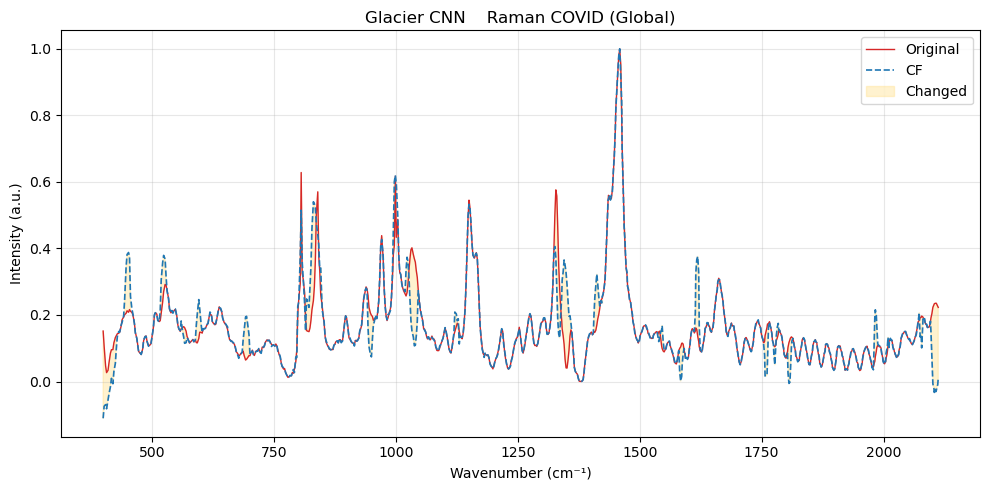

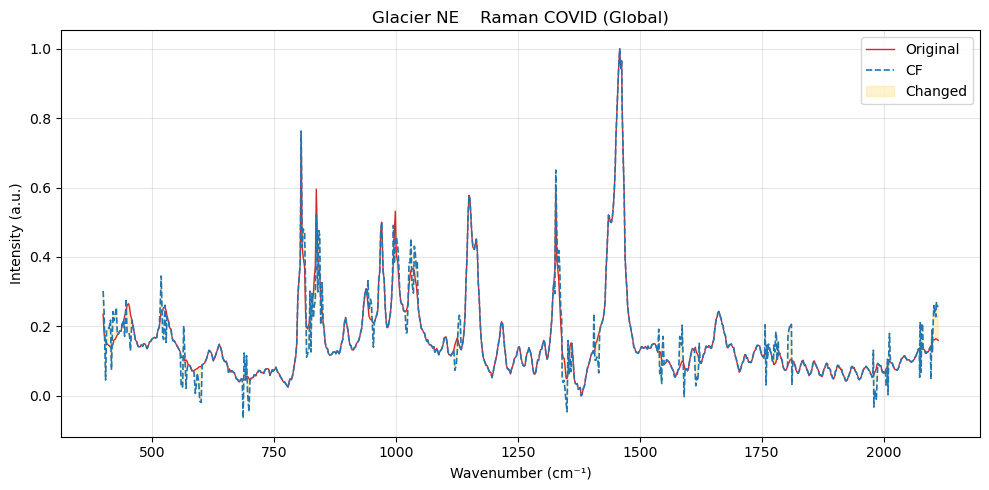

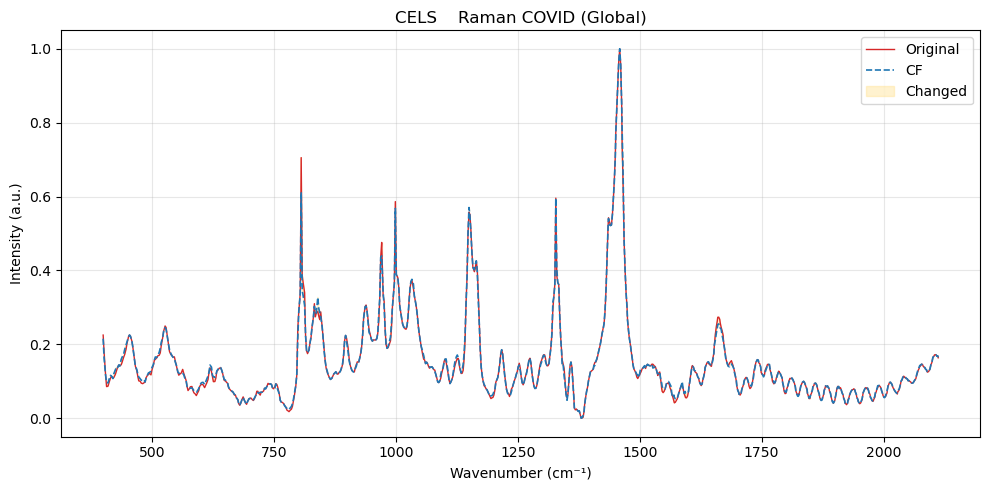

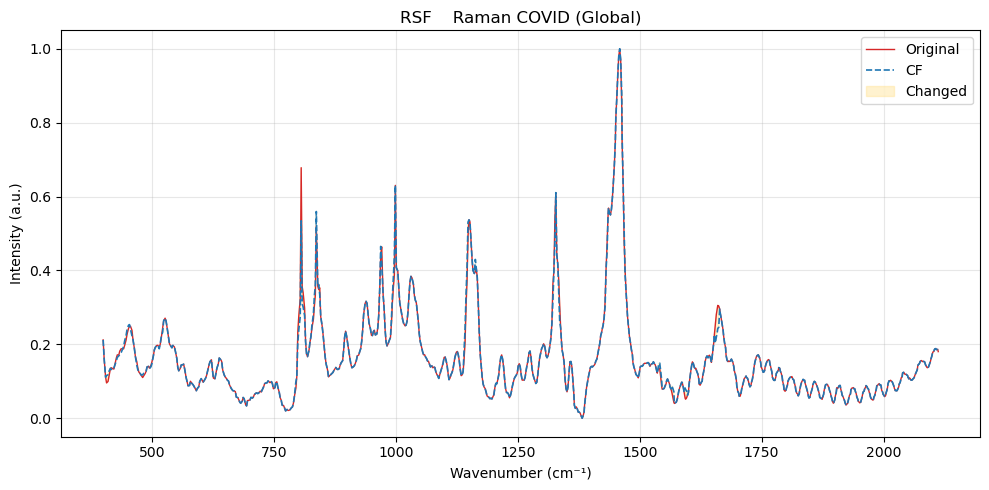


STATISTICS (GLOBAL mode)

Glacier CNN:
  Distances: 1.751
  Mean: 1.751, Std: 0.000

Glacier NE:
  Distances: 0.975
  Mean: 0.975, Std: 0.000

CELS:
  Distances: 0.193
  Mean: 0.193, Std: 0.000

RSF:
  Distances: 0.285
  Mean: 0.285, Std: 0.000


In [100]:
#show_best_examples("RamanCOVID19_ramanspy_preprocessed", n_examples=1, mode="global")

# Show more examples
show_best_examples("RamanCOVID19_ramanspy_preprocessed", 
                   n_examples=1, mode="global",
                   dataset_display_name="   Raman COVID")

# Visualisation

In [40]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

THR = 0.04

def _compare_signals(sig_a, sig_b, tol=1e-6):
    """Return True if signals match within tolerance."""
    return np.allclose(sig_a, sig_b, atol=tol, rtol=0)

def _collect_glacier(root_path, kind, meth):
    out = []
    data_path = root_path / kind
    
    for npz_file in data_path.glob(f"cf_fold*_{meth}.npz"):
        with np.load(npz_file) as Z:
            x0, xcf = Z["x_orig"], Z["x_cf"]
            y_true, y0, ycf = Z["y_true"], Z["y_pred"], Z["y_cf"]
            
            for i, (o, c, t, a, b) in enumerate(zip(x0, xcf, y_true, y0, ycf)):
                tag = f"{npz_file.name}:{i}"
                out.append({
                    "x0": o, "xcf": c, 
                    "y_true": int(t), "y0": int(a), "ycf": int(b), 
                    "tag": tag
                })
            
    if not out:
        print(f"Warning: No Glacier CFs found for {data_path}")
    return out


def _collect_cels(root_path, mode):
    out = []
    data_path = root_path / mode

    for npz_file in data_path.glob("cf_fold*.npz"):
        with np.load(npz_file, allow_pickle=True) as Z:
            x0_batch, xcf_batch = Z["x0"], Z["xcf"]
            y_true_batch, y0_batch, ycf_batch = Z["y_true"], Z["y_pred"], Z["y_cf"]
            tags_batch = Z["tag"]
            
            for i in range(len(x0_batch)):
                tag = f"{npz_file.name}:{i} ({tags_batch[i]})"
                out.append({
                    "x0": x0_batch[i], "xcf": xcf_batch[i],
                    "y_true": int(y_true_batch[i]),
                    "y0": int(y0_batch[i]),
                    "ycf": int(ycf_batch[i]),
                    "tag": tag
                })

    if not out:
        print(f"Warning: No CELS CFs found for {data_path}")
    return out


def _collect_rsf(root_path, mode):
    """Collect RSF counterfactuals"""
    out = []
    data_path = root_path / mode / "rsf"
    
    for npz_file in data_path.glob("cf_fold*.npz"):
        with np.load(npz_file) as Z:
            x0_batch, xcf_batch = Z["x0"], Z["xcf"]
            y_true_batch, y0_batch, ycf_batch = Z["y_true"], Z["y_pred"], Z["y_cf"]
            
            for i in range(len(x0_batch)):
                tag = f"{npz_file.name}:{i}"
                out.append({
                    "x0": x0_batch[i], "xcf": xcf_batch[i],
                    "y_true": int(y_true_batch[i]),
                    "y0": int(y0_batch[i]),
                    "ycf": int(ycf_batch[i]),
                    "tag": tag
                })
    
    if not out:
        print(f"Warning: No RSF CFs found for {data_path}")
    return out


def _plot_cf(ax, item, title):
    """Plot a single counterfactual comparison"""
    x0, xcf = item["x0"], item["xcf"]
    y_true, y0, ycf = item["y_true"], item["y0"], item["ycf"]

    x0 = np.squeeze(x0)
    xcf = np.squeeze(xcf)

    delta = np.abs(xcf - x0)
    changed = delta > THR

    ax.plot(x0, lw=0.7, color="#d62728", label=f"Original")
    ax.plot(xcf, lw=1.1, color="grey", ls=":", label=f"CF")

    ax.fill_between(
        np.arange(len(x0)), 0, 1, where=changed,
        color="#ffdf88", alpha=0.35
    )

    
    ax.set_title(f"{title}", fontsize=12)
    ax.legend(loc="upper right")


def view(dataset_name, glacier_methods=["cnn", "ne"], meaningful_only=False):
    
    GLACIER_ROOT = Path("Glacier/learning-time-series-counterfactuals/cf_runs") / dataset_name
    CELS_ROOT = Path("CELS/CELS/cf_runs") / dataset_name
    RSF_ROOT = Path("RSF/RSF/cf_runs") / dataset_name

    # Collect Glacier data for all specified methods
    glacier_data = {}
    for meth in glacier_methods:
        print(f"Loading Glacier {meth.upper()} (Local)...")
        glacier_data[f"{meth}_local"] = _collect_glacier(GLACIER_ROOT, "local", meth)
        
        print(f"Loading Glacier {meth.upper()} (Global)...")
        glacier_data[f"{meth}_global"] = _collect_glacier(GLACIER_ROOT, "global", meth)

    print("Loading CELS (Local)...")
    cels_local = _collect_cels(CELS_ROOT, "local")

    print("Loading CELS (Global)...")
    cels_global = _collect_cels(CELS_ROOT, "global")

    print("Loading RSF (Local)...")
    rsf_local = _collect_rsf(RSF_ROOT, "local")
    
    print("Loading RSF (Global)...")
    rsf_global = _collect_rsf(RSF_ROOT, "global")

    # Calculate number of rows needed
    num_glacier_methods = len(glacier_methods)
    num_rows = num_glacier_methods + 2  # Glacier methods + CELS + RSF
    
    all_datasets = list(glacier_data.values()) + [cels_local, cels_global, rsf_local, rsf_global]
    n = max(len(d) for d in all_datasets if d)
    
    # Filter for indices where ALL methods have meaningful CFs if requested
    valid_indices = None
    if meaningful_only:
        def is_meaningful(item):
            return item["y0"] == item["y_true"] and item["y0"] != item["ycf"]
        
        # Get the minimum length across all datasets
        min_len = min(len(d) for d in all_datasets if d)
        
        # Find indices where ALL datasets have meaningful CFs
        valid_indices = []
        for idx in range(min_len):
            all_meaningful = True
            
            # Check all glacier methods
            for key in glacier_data:
                if glacier_data[key] and not is_meaningful(glacier_data[key][idx]):
                    all_meaningful = False
                    break
            
            # Check CELS
            if all_meaningful and cels_local and not is_meaningful(cels_local[idx]):
                all_meaningful = False
            if all_meaningful and cels_global and not is_meaningful(cels_global[idx]):
                all_meaningful = False
            
            # Check RSF
            if all_meaningful and rsf_local and not is_meaningful(rsf_local[idx]):
                all_meaningful = False
            if all_meaningful and rsf_global and not is_meaningful(rsf_global[idx]):
                all_meaningful = False
            
            if all_meaningful:
                valid_indices.append(idx)
        
        n = len(valid_indices)
        print(f"\nFiltered to {n} indices where ALL methods have meaningful CFs")

    def _show(idx=0):
        # Map slider index to actual data index if filtering
        actual_idx = valid_indices[idx] if valid_indices is not None else idx
        
        fig, axes = plt.subplots(num_rows, 2, figsize=(16, 4 * num_rows), sharex=True)
        
        # Build data layout - each row has Global (left) and Local (right)
        data_layout = []
        
        # Add Glacier methods
        for meth in glacier_methods:
            data_layout.append((
                f"Glacier {meth.upper()} Global", 
                glacier_data[f"{meth}_global"],
                f"Glacier {meth.upper()} Local", 
                glacier_data[f"{meth}_local"]
            ))
        
        # Add CELS and RSF
        data_layout.extend([
            ("CELS Global", cels_global, "CELS Local", cels_local),
            ("RSF Global", rsf_global, "RSF Local", rsf_local)
        ])

        for row, (global_title, global_data, local_title, local_data) in enumerate(data_layout):
            # Global (left column)
            ax_global = axes[row, 0]
            if not global_data:
                ax_global.text(0.5, 0.5, "No data", ha='center', va='center', style='italic')
                ax_global.set_title(f"{global_title}", fontsize=10)
            else:
                item = global_data[actual_idx % len(global_data)]
                _plot_cf(ax_global, item, global_title)

            # Local (right column)
            ax_local = axes[row, 1]
            if not local_data:
                ax_local.text(0.5, 0.5, "No data", ha='center', va='center', style='italic')
                ax_local.set_title(f"{local_title}", fontsize=10)
            else:
                item = local_data[actual_idx % len(local_data)]
                _plot_cf(ax_local, item, local_title)

        # Signal comparison (using first Glacier method)
        first_glacier_global = glacier_data[f"{glacier_methods[1]}_global"]
        if first_glacier_global and cels_global and rsf_global:
            sig_g = np.squeeze(first_glacier_global[actual_idx % len(first_glacier_global)]["x0"])
            sig_c = np.squeeze(cels_global[actual_idx % len(cels_global)]["x0"])
            sig_r = np.squeeze(rsf_global[actual_idx % len(rsf_global)]["x0"])

            print(f"Index {actual_idx} | "
                f"Glacier vs CELS: {_compare_signals(sig_g, sig_c)} | "
                f"Glacier vs RSF: {_compare_signals(sig_g, sig_r)} | "
                f"CELS vs RSF: {_compare_signals(sig_c, sig_r)}")
        
        # Set x-labels only for bottom row
        axes[-1, 0].set_xlabel("Spectral Index")
        axes[-1, 1].set_xlabel("Spectral Index")
        
        plt.tight_layout()
        plt.show()

    interact(
        _show,
        idx=IntSlider(0, 0, n - 1, 1, description='Sample Index', continuous_update=False)
    )

In [ ]:
view(dataset_name="EcoliVsKpneumoniae_ramanspy_singular", meaningful_only=True)
view(dataset_name="RamanCOVID19_ramanspy_preprocessed", meaningful_only=True)
view(dataset_name="DRS_TissueClassification", meaningful_only=True)

Loading Glacier CNN (Local)...
Loading Glacier CNN (Global)...
Loading Glacier NE (Local)...
Loading Glacier NE (Global)...
Loading CELS (Local)...
Loading CELS (Global)...
Loading RSF (Local)...
Loading RSF (Global)...

Filtered to 8 indices where ALL methods have meaningful CFs


interactive(children=(IntSlider(value=0, continuous_update=False, description='Sample Index', max=7), Output()…

Loading Glacier CNN (Local)...
Loading Glacier CNN (Global)...
Loading Glacier NE (Local)...
Loading Glacier NE (Global)...
Loading CELS (Local)...
Loading CELS (Global)...
Loading RSF (Local)...
Loading RSF (Global)...

Filtered to 58 indices where ALL methods have meaningful CFs


interactive(children=(IntSlider(value=0, continuous_update=False, description='Sample Index', max=57), Output(…

Loading Glacier CNN (Local)...
Loading Glacier CNN (Global)...
Loading Glacier NE (Local)...
Loading Glacier NE (Global)...
Loading CELS (Local)...
Loading CELS (Global)...
Loading RSF (Local)...
Loading RSF (Global)...

Filtered to 129 indices where ALL methods have meaningful CFs


interactive(children=(IntSlider(value=0, continuous_update=False, description='Sample Index', max=128), Output…

In [ ]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

THR = 0.04

def _compare_signals(sig_a, sig_b, tol=1e-6):
    """Return True if signals match within tolerance."""
    return np.allclose(sig_a, sig_b, atol=tol, rtol=0)

def _collect_glacier(root_path, kind, meth):
    out = []
    data_path = root_path / kind
    
    for npz_file in data_path.glob(f"cf_fold*_{meth}.npz"):
        with np.load(npz_file) as Z:
            x0, xcf = Z["x_orig"], Z["x_cf"]
            y_true, y0, ycf = Z["y_true"], Z["y_pred"], Z["y_cf"]
            
            for i, (o, c, t, a, b) in enumerate(zip(x0, xcf, y_true, y0, ycf)):
                tag = f"{npz_file.name}:{i}"
                out.append({
                    "x0": o, "xcf": c, 
                    "y_true": int(t), "y0": int(a), "ycf": int(b), 
                    "tag": tag
                })
            
    if not out:
        print(f"Warning: No Glacier CFs found for {data_path}")
    return out


def _collect_cels(root_path, mode):
    out = []
    data_path = root_path / mode

    for npz_file in data_path.glob("cf_fold*.npz"):
        with np.load(npz_file, allow_pickle=True) as Z:
            x0_batch, xcf_batch = Z["x0"], Z["xcf"]
            y_true_batch, y0_batch, ycf_batch = Z["y_true"], Z["y_pred"], Z["y_cf"]
            tags_batch = Z["tag"]
            
            for i in range(len(x0_batch)):
                tag = f"{npz_file.name}:{i} ({tags_batch[i]})"
                out.append({
                    "x0": x0_batch[i], "xcf": xcf_batch[i],
                    "y_true": int(y_true_batch[i]),
                    "y0": int(y0_batch[i]),
                    "ycf": int(ycf_batch[i]),
                    "tag": tag
                })

    if not out:
        print(f"Warning: No CELS CFs found for {data_path}")
    return out


def _collect_rsf(root_path, mode):
    """Collect RSF counterfactuals"""
    out = []
    data_path = root_path / mode / "rsf"
    
    for npz_file in data_path.glob("cf_fold*.npz"):
        with np.load(npz_file) as Z:
            x0_batch, xcf_batch = Z["x0"], Z["xcf"]
            y_true_batch, y0_batch, ycf_batch = Z["y_true"], Z["y_pred"], Z["y_cf"]
            
            for i in range(len(x0_batch)):
                tag = f"{npz_file.name}:{i}"
                out.append({
                    "x0": x0_batch[i], "xcf": xcf_batch[i],
                    "y_true": int(y_true_batch[i]),
                    "y0": int(y0_batch[i]),
                    "ycf": int(ycf_batch[i]),
                    "tag": tag
                })
    
    if not out:
        print(f"Warning: No RSF CFs found for {data_path}")
    return out



def view(dataset_name, glacier_meth="cnn"):
    
    GLACIER_ROOT = Path("Glacier/learning-time-series-counterfactuals/cf_runs") / dataset_name
    CELS_ROOT = Path("CELS/CELS/cf_runs") / dataset_name
    RSF_ROOT = Path("RSF/RSF/cf_runs") / dataset_name

    print("Loading Glacier (Local)...")
    glacier_local = _collect_glacier(GLACIER_ROOT, "local", glacier_meth)
    
    print("Loading Glacier (Global)...")
    glacier_global = _collect_glacier(GLACIER_ROOT, "global", glacier_meth)

    print("Loading CELS (Local)...")
    cels_local = _collect_cels(CELS_ROOT, "local")

    print("Loading CELS (Global)...")
    cels_global = _collect_cels(CELS_ROOT, "global")

    print("Loading RSF (Local)...")
    rsf_local = _collect_rsf(RSF_ROOT, "local")
    
    print("Loading RSF (Global)...")
    rsf_global = _collect_rsf(RSF_ROOT, "global")

    n = max(len(d) for d in [glacier_local, glacier_global, cels_local, cels_global, rsf_local, rsf_global] if d)


    def _show(idx=0):
        fig, axes = plt.subplots(3, 2, figsize=(16, 12), sharex=True)
        
        # Left column: Global methods
        # Right column: Local methods
        data_layout = [
            ("Glacier GLOBAL", glacier_global, "Glacier LOCAL", glacier_local),
            ("CELS GLOBAL", cels_global, "CELS LOCAL", cels_local),
            ("RSF GLOBAL", rsf_global, "RSF LOCAL", rsf_local)
        ]

        for row, (global_title, global_data, local_title, local_data) in enumerate(data_layout):
            # Global (left column)
            ax_global = axes[row, 0]
            if not global_data:
                ax_global.set_title(f"{global_title} - No data found", fontsize=10)
                ax_global.text(0.5, 0.5, "No data", ha='center', va='center', style='italic')
            else:
                item = global_data[idx % len(global_data)]
                _plot_cf(ax_global, item, global_title)

            # Local (right column)
            ax_local = axes[row, 1]
            if not local_data:
                ax_local.set_title(f"{local_title} - No data found", fontsize=10)
                ax_local.text(0.5, 0.5, "No data", ha='center', va='center', style='italic')
            else:
                item = local_data[idx % len(local_data)]
                _plot_cf(ax_local, item, local_title)

        if glacier_global and cels_global and rsf_global:
            sig_g = np.squeeze(glacier_global[idx % len(glacier_global)]["x0"])
            sig_c = np.squeeze(cels_global[idx % len(cels_global)]["x0"])
            sig_r = np.squeeze(rsf_global[idx % len(rsf_global)]["x0"])

            print(f"Index {idx} | "
                f"Glacier vs CELS: {_compare_signals(sig_g, sig_c)} | "
                f"Glacier vs RSF: {_compare_signals(sig_g, sig_r)} | "
                f"CELS vs RSF: {_compare_signals(sig_c, sig_r)}")
        # Set x-labels only for bottom row
        axes[2, 0].set_xlabel("Spectral Index")
        axes[2, 1].set_xlabel("Spectral Index")
        
        plt.tight_layout()
        plt.show()

    def _plot_cf(ax, item, title):
        x0, xcf = item["x0"], item["xcf"]
        y_true, y0, ycf = item["y_true"], item["y0"], item["ycf"]
        tag = item["tag"]

        x0 = np.squeeze(x0)
        xcf = np.squeeze(xcf)

        delta = np.abs(xcf - x0)
        changed = delta > THR
        sparsity = np.mean(changed)
        proximity = np.linalg.norm(x0 - xcf)

        ax.plot(x0, lw=1, color="#d62728", label=f"Original (true={y_true}, pred={y0})")
        ax.plot(xcf, lw=0.7, color="grey", ls="--", label=f"CF (ŷ={ycf})")

        ax.fill_between(
            np.arange(len(x0)), 0, 1, where=changed,
            color="#ffdf88", alpha=0.35
        )

        meaningful_cf = (y0 == y_true) and (y0 != ycf)
        meaningful_str = " [Meaningful CF]" if meaningful_cf else ""
        
        ax.set_title(
            f"{title} | Sparsity: {sparsity:.1%} | Proximity: {proximity:.2f}{meaningful_str}\n(Source: {tag})",
            fontsize=10
        )
        ax.legend(loc="upper right")

    interact(
        _show,
        idx=IntSlider(0, 0, n - 1, 1, description='Sample Index', continuous_update=False)
    )

In [ ]:
view(dataset_name="EcoliVsKpneumoniae_ramanspy_singular")
view(dataset_name="RamanCOVID19_ramanspy_preprocessed")
view(dataset_name="DRS_TissueClassification")

Loading Glacier CNN (Local)...
Loading Glacier CNN (Global)...
Loading Glacier NE (Local)...
Loading Glacier NE (Global)...
Loading CELS (Local)...
Loading CELS (Global)...
Loading RSF (Local)...
Loading RSF (Global)...


interactive(children=(IntSlider(value=0, continuous_update=False, description='Sample Index', max=499), Output…

Loading Glacier CNN (Local)...
Loading Glacier CNN (Global)...
Loading Glacier NE (Local)...
Loading Glacier NE (Global)...
Loading CELS (Local)...
Loading CELS (Global)...
Loading RSF (Local)...
Loading RSF (Global)...


interactive(children=(IntSlider(value=0, continuous_update=False, description='Sample Index', max=308), Output…

Loading Glacier CNN (Local)...
Loading Glacier CNN (Global)...
Loading Glacier NE (Local)...
Loading Glacier NE (Global)...
Loading CELS (Local)...
Loading CELS (Global)...
Loading RSF (Local)...
Loading RSF (Global)...


interactive(children=(IntSlider(value=0, continuous_update=False, description='Sample Index', max=499), Output…

# Closest CFs

In [29]:
import numpy as np
from pathlib import Path

ROOT = Path.home() / "local-datasets" / "covid19"
wavenumbers = np.loadtxt(ROOT / "wave_number.txt")

print("Axis length:", len(wavenumbers))
print("First 10 values:", wavenumbers[:10])

Axis length: 900
First 10 values: [400. 402. 405. 407. 410. 412. 415. 417. 420. 422.]


In [42]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

# --- Utility + selection (only new parts we need) ---
def average_waveform(dataset, target_class):
    signals = [np.squeeze(s["x0"]) for s in dataset if s["y_true"] == target_class]
    if not signals:
        return None
    return np.mean(np.vstack(signals), axis=0)

def select_top_cf(dataset, k=20):
    if not dataset:
        return []
    out = []
    for s in dataset:
        y_true, y_cf = s["y_true"], s["ycf"]
        if y_cf == y_true:
            continue
        alt_class = 1 - y_true
        alt_mean = average_waveform(dataset, alt_class)
        if alt_mean is None:
            continue
        dist_to_alt = np.linalg.norm(np.squeeze(s["xcf"]) - alt_mean)
        out.append({**s, "dist_to_alt": dist_to_alt})
    out.sort(key=lambda s: s["dist_to_alt"])
    return out[:k]

def select_top_cf_by_class(dataset, k=10):
    if not dataset:
        return {}

    all_classes = sorted(set(s["y_true"] for s in dataset))
    if len(all_classes) != 2:
        raise ValueError(f"Expected binary labels, got {all_classes}")

    results = {}
    for cls in all_classes:
        out = []
        for s in dataset:
            if s["y_true"] != cls:
                continue
            if s["y0"] != s["y_true"]:
                continue  # discard misclassified originals
            if s["ycf"] == s["y_true"]:
                continue  # skip CFs that don't flip

            alt_class = 1 - s["y_true"]
            alt_mean = average_waveform(dataset, alt_class)
            if alt_mean is None:
                continue

            dist_to_alt = np.linalg.norm(np.squeeze(s["xcf"]) - alt_mean)
            out.append({**s, "dist_to_alt": dist_to_alt})

        out.sort(key=lambda s: s["dist_to_alt"])
        results[cls] = out[:k]

    return results

def plot_cf_interactive(cf_list, title, x_axis=None):
    if not cf_list:
        print(f"No CFs found for {title}")
        return

    provided_axis = x_axis 

    def _show(idx=0):
        s = cf_list[idx]
        x0, xcf = np.squeeze(s["x0"]), np.squeeze(s["xcf"])
        y_true, y0, ycf = s["y_true"], s["y0"], s["ycf"]
        tag = s["tag"]

        x_axis = provided_axis if provided_axis is not None else np.arange(len(x0))

        plt.figure(figsize=(16,4))
        plt.plot(x_axis, x0, color="red", lw=1,
                 label=f"Original (true={y_true}, pred={y0})")
        plt.plot(x_axis, xcf, color="blue", lw=0.8, ls="--",
                 label=f"CF (ŷ={ycf})")

        alt_class = 1 - y_true
        alt_mean = average_waveform(cf_list, alt_class)
        if alt_mean is not None and len(alt_mean) == len(x_axis):
            plt.plot(x_axis, alt_mean, color="green", lw=1, alpha=0.6,
                     label=f"Mean of class {alt_class}")

        plt.xlabel("Raman shift (cm$^{-1}$)")
        plt.title(f"{title} | {tag}\n"
                  f"dist_to_alt={s['dist_to_alt']:.2f}")
        plt.legend()
        plt.show()

    interact(_show, idx=IntSlider(0, 0, len(cf_list)-1, 1, description="CF index"))

# --- Collect datasets using your pre-existing collectors ---
dataset_name = "RamanCOVID19_ramanspy_preprocessed"   # 👈 change to your dataset
glacier_root = Path("Glacier/learning-time-series-counterfactuals/cf_runs") / dataset_name
cels_root    = Path("CELS/CELS/cf_runs") / dataset_name
rsf_root     = Path("RSF/RSF/cf_runs") / dataset_name

glacier_global = _collect_glacier(glacier_root, "global", "cnn")
glacier_local  = _collect_glacier(glacier_root, "local", "cnn")
cels_global    = _collect_cels(cels_root, "global")
cels_local     = _collect_cels(cels_root, "local")
rsf_global     = _collect_rsf(rsf_root, "global")
rsf_local      = _collect_rsf(rsf_root, "local")

# --- Select top-20 per method/mode ---
results = {
    "Glacier Global": select_top_cf(glacier_global, 20),
    "Glacier Local":  select_top_cf(glacier_local, 20),
    "CELS Global":    select_top_cf(cels_global, 20),
    "CELS Local":     select_top_cf(cels_local, 20),
    "RSF Global":     select_top_cf(rsf_global, 20),
    "RSF Local":      select_top_cf(rsf_local, 20),
}




In [38]:
plot_cf_interactive(results["Glacier Global"], "Glacier Global Top-20", x_axis=wavenumbers)
plot_cf_interactive(results["Glacier Local"], "Glacier Local Top-20", x_axis=wavenumbers)
plot_cf_interactive(results["CELS Global"], "CELS Global Top-20", x_axis=wavenumbers)
plot_cf_interactive(results["CELS Local"], "CELS Local Top-20", x_axis=wavenumbers)
plot_cf_interactive(results["RSF Global"], "RSF Global Top-20", x_axis=wavenumbers)
plot_cf_interactive(results["RSF Local"], "RSF Local Top-20", x_axis=wavenumbers)

interactive(children=(IntSlider(value=0, description='CF index', max=19), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=0, description='CF index', max=19), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=0, description='CF index', max=19), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=0, description='CF index', max=19), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=0, description='CF index', max=19), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=0, description='CF index', max=19), Output()), _dom_classes=('widget-int…

In [43]:
rsf_local_best = select_top_cf_by_class(rsf_local, k=10)
rsf_global_best = select_top_cf_by_class(rsf_global, k=10)

plot_cf_interactive(rsf_local_best[0], "RSF Local Top-10 from class 0", x_axis=wavenumbers)
plot_cf_interactive(rsf_local_best[1], "RSF Local Top-10 from class 1", x_axis=wavenumbers)

plot_cf_interactive(rsf_global_best[0], "RSF Global Top-10 from class 0", x_axis=wavenumbers)
plot_cf_interactive(rsf_global_best[1], "RSF Global Top-10 from class 1", x_axis=wavenumbers)

interactive(children=(IntSlider(value=0, description='CF index', max=9), Output()), _dom_classes=('widget-inte…

interactive(children=(IntSlider(value=0, description='CF index', max=9), Output()), _dom_classes=('widget-inte…

interactive(children=(IntSlider(value=0, description='CF index', max=9), Output()), _dom_classes=('widget-inte…

interactive(children=(IntSlider(value=0, description='CF index', max=9), Output()), _dom_classes=('widget-inte…

In [47]:
import random, json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import resample


def average_waveform(dataset, target_class):
    signals = [np.squeeze(s["x0"]) for s in dataset if s["y_true"] == target_class]
    if not signals:
        return None
    return np.mean(np.vstack(signals), axis=0)


def select_top_cf_by_class(dataset, k=5):
    """Top-k CFs per class, closest to opposite-class mean."""
    if not dataset:
        return {}

    all_classes = sorted(set(s["y_true"] for s in dataset))
    if len(all_classes) != 2:
        raise ValueError(f"Expected binary labels, got {all_classes}")

    results = {}
    for cls in all_classes:
        out = []
        for s in dataset:
            if s["y_true"] != cls:
                continue
            if s["y0"] != s["y_true"]:
                continue  # must be correctly classified originally
            if s["ycf"] == s["y_true"]:
                continue  # CF must flip

            alt_class = 1 - s["y_true"]
            alt_mean = average_waveform(dataset, alt_class)
            if alt_mean is None:
                continue

            dist_to_alt = np.linalg.norm(np.squeeze(s["xcf"]) - alt_mean)
            out.append({**s, "dist_to_alt": dist_to_alt})

        out.sort(key=lambda s: s["dist_to_alt"])
        results[cls] = out[:k]

    return results


# --- Save blind quiz (5 CFs + 5 trues per class = 20 total) ---
def save_balanced_blind_quiz(dataset, out_dir, x_axis=None, k=5, seed=4):
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    # --- CFs ---
    cf_by_class = select_top_cf_by_class(dataset, k=k)

    # --- True signals ---
    true_by_class = {}
    for cls in sorted(set(s["y_true"] for s in dataset)):
        true_by_class[cls] = [
            s["x0"] for s in dataset if s["y_true"] == cls and s["y0"] == s["y_true"]
        ]
        random.Random(seed).shuffle(true_by_class[cls])
        true_by_class[cls] = true_by_class[cls][:k]

    # --- Mix items ---
    items = []
    for cls in cf_by_class:
        items.extend([(s["xcf"], "cf", cls, s) for s in cf_by_class[cls]])
        items.extend([(s, "true", cls, s) for s in true_by_class[cls]])

    random.Random(seed).shuffle(items)

    key = {}
    provided_axis = x_axis

    for idx, (signal, label, cls, s) in enumerate(items):
        sig = np.squeeze(signal)
        axis = provided_axis if provided_axis is not None else np.arange(len(sig))

        if len(axis) != len(sig):
            axis = resample(axis, len(sig))

        plt.figure(figsize=(12,4))
        plt.plot(axis, sig, color="black", lw=1)
        plt.xlabel("Raman shift (cm$^{-1}$)")
        plt.ylabel("Intensity (a.u.)")

        fname = f"signal_{idx}.png"
        out_file = out_dir / fname
        plt.savefig(out_file, dpi=150, bbox_inches="tight")
        plt.close()

        if label == "cf":
            key[fname] = {"type": "cf", "class": int(s["ycf"])}
        else:
            key[fname] = {"type": "true", "class": int(cls)}

    return key


# --- Run for all methods ---
all_datasets = {
    "RSF_Local": rsf_local,
    "RSF_Global": rsf_global,
}

for name, data in all_datasets.items():
    if not data:
        print(f"[{name}] No data, skipping.")
        continue

    print(f"[{name}] Exporting blind quiz images...")
    key_map = save_balanced_blind_quiz(
        data,
        out_dir=f"cf_images/blind_{name}",
        x_axis=wavenumbers,
        k=5,
        seed=42
    )

    with open(f"cf_images/blind_{name}/key_map.json", "w") as f:
        json.dump(key_map, f, indent=2)

print(" Done. Blind quizzes saved in cf_images/")


[RSF_Local] Exporting blind quiz images...
[RSF_Global] Exporting blind quiz images...
 Done. Blind quizzes saved in cf_images/


# Metrics

In [57]:
from pathlib import Path
import numpy as np
import pandas as pd
from IPython.display import display

def per_sample_metrics(x0, xcf, y0, ycf, thr):
    x0 = np.asarray(x0).ravel()
    xcf = np.asarray(xcf).ravel()
    delta = xcf - x0
    
    l2_abs = float(np.linalg.norm(delta))
    l2_rel = float(l2_abs / (np.linalg.norm(x0) + 1e-12))
    sparsity = float(np.mean(np.abs(delta) > thr))
    validity = int(int(ycf) != int(y0))
    
    return l2_abs, l2_rel, sparsity, validity

def calculate_and_display_metrics(dataset_name, glacier_meth="cnn", threshold=0.025):
    print(f"--- Calculating Metrics for: {dataset_name} ---")
    
    GLACIER_ROOT = Path("Glacier/learning-time-series-counterfactuals/cf_runs") / dataset_name
    CELS_ROOT = Path("CELS/CELS/cf_runs") / dataset_name
    RSF_ROOT = Path("RSF/RSF/cf_runs") / dataset_name

    all_sets = {
        "Glacier_local": _collect_glacier(GLACIER_ROOT, "local", glacier_meth),
        "Glacier_global": _collect_glacier(GLACIER_ROOT, "global", glacier_meth),
        "CELS_local": _collect_cels(CELS_ROOT, "local"),
        "CELS_global": _collect_cels(CELS_ROOT, "global"),
        "RSF_local": _collect_rsf(RSF_ROOT, "local"),
        "RSF_global": _collect_rsf(RSF_ROOT, "global"),
    }

    rows = []
    for name, items in all_sets.items():
        if not items:
            print(f"No '{name}', skipping.")
            continue
            
        for it in items:
            l2_abs, l2_rel, spars, valid = per_sample_metrics(it["x0"], it["xcf"], it["y0"], it["ycf"], threshold)
            rows.append({
                "Method": name,
                "proximity_abs": l2_abs,
                "proximity_rel": l2_rel,
                "sparsity": spars,
                "validity": valid,
            })

    df = pd.DataFrame(rows)
    
    agg = df.groupby("Method").agg(
        N=("validity", "size"),
        **{
            "Avg Rel Proximity": ("proximity_rel", "mean"),
            "Std Rel Proximity": ("proximity_rel", "std"),
            "Median Rel Proximity": ("proximity_rel", "median"),
            "Avg Sparsity": ("sparsity", "mean"),
            "Std Sparsity": ("sparsity", "std"),
            "Median Sparsity": ("sparsity", "median"),
            "Validity": ("validity", "mean"),
        }
    ).reset_index()

    pretty = agg.copy()
    pretty["Avg Rel Proximity"] = pretty["Avg Rel Proximity"].round(4)
    pretty["Std Rel Proximity"] = pretty["Std Rel Proximity"].round(4)
    pretty["Median Rel Proximity"] = pretty["Median Rel Proximity"].round(4)
    pretty["Avg Sparsity"] = (pretty["Avg Sparsity"] * 100).round(2).astype(str) + "%"
    pretty["Std Sparsity"] = (pretty["Std Sparsity"] * 100).round(2).astype(str) + "%"
    pretty["Median Sparsity"] = (pretty["Median Sparsity"] * 100).round(2).astype(str) + "%"
    pretty["Validity"] = (pretty["Validity"] * 100).round(2).astype(str) + "%"

    print("\n--- Aggregated Results ---")
    display(pretty.style.hide(axis='index'))
    return agg

def compare_methods_statistical(dataset_name, glacier_meth="cnn", threshold=0.025):
    """Additional function to provide statistical comparisons between methods"""
    print(f"--- Statistical Comparison for: {dataset_name} ---")

    # Get raw aggregated data
    agg = calculate_and_display_metrics(dataset_name, glacier_meth, threshold)

    if agg is None:
        return
    # Find best performing methods for each metric
    print("\n--- Best Performers ---")
    best_validity = agg.loc[agg['Validity'].idxmax()]
    print(f"Best Validity: {best_validity['Method']} ({best_validity['Validity']:.1%})")

    best_proximity = agg.loc[agg['Avg Rel Proximity'].idxmin()]
    print(f"Best Proximity: {best_proximity['Method']} ({best_proximity['Avg Rel Proximity']:.4f})")

    best_sparsity = agg.loc[agg['Avg Sparsity'].idxmin()]
    print(f"Best Sparsity: {best_sparsity['Method']} ({best_sparsity['Avg Sparsity']:.1%})")

    #return agg

In [59]:
compare_methods_statistical("DRS_TissueClassification")
compare_methods_statistical("EcoliVsKpneumoniae_ramanspy_singular")
compare_methods_statistical("RamanCOVID19_ramanspy_preprocessed")

--- Statistical Comparison for: DRS_TissueClassification ---
--- Calculating Metrics for: DRS_TissueClassification ---

--- Aggregated Results ---


Method,N,Avg Rel Proximity,Std Rel Proximity,Median Rel Proximity,Avg Sparsity,Std Sparsity,Median Sparsity,Validity
CELS_global,500,0.074100,0.029000,0.070200,31.99%,10.2%,32.4%,99.2%
CELS_local,500,0.028200,0.016900,0.028100,3.34%,2.52%,2.78%,48.2%
Glacier_global,500,0.049600,0.016300,0.046000,16.97%,3.49%,16.92%,99.4%
Glacier_local,500,0.055600,0.018900,0.053600,24.49%,16.51%,18.06%,98.8%
RSF_global,1250,0.134300,0.048500,0.136700,9.82%,0.62%,9.99%,55.92%
RSF_local,1250,0.081900,0.032100,0.080300,45.92%,17.38%,47.39%,98.88%



--- Best Performers ---
Best Validity: Glacier_global (99.4%)
Best Proximity: CELS_local (0.0282)
Best Sparsity: CELS_local (3.3%)
--- Statistical Comparison for: EcoliVsKpneumoniae_ramanspy_singular ---
--- Calculating Metrics for: EcoliVsKpneumoniae_ramanspy_singular ---

--- Aggregated Results ---


Method,N,Avg Rel Proximity,Std Rel Proximity,Median Rel Proximity,Avg Sparsity,Std Sparsity,Median Sparsity,Validity
CELS_global,500,0.094900,0.013100,0.092900,18.95%,1.79%,18.8%,25.0%
CELS_local,500,0.140800,0.023500,0.143900,10.91%,4.59%,10.7%,76.4%
Glacier_global,500,0.076700,0.015100,0.074400,17.21%,3.67%,16.3%,98.8%
Glacier_local,500,0.069000,0.016600,0.066200,16.7%,5.97%,16.0%,98.8%
RSF_global,1250,0.101800,0.021400,0.098400,8.72%,0.54%,8.7%,7.52%
RSF_local,1250,0.072300,0.036600,0.078500,30.53%,17.38%,33.95%,82.72%



--- Best Performers ---
Best Validity: Glacier_global (98.8%)
Best Proximity: Glacier_local (0.0690)
Best Sparsity: RSF_global (8.7%)
--- Statistical Comparison for: RamanCOVID19_ramanspy_preprocessed ---
--- Calculating Metrics for: RamanCOVID19_ramanspy_preprocessed ---

--- Aggregated Results ---


Method,N,Avg Rel Proximity,Std Rel Proximity,Median Rel Proximity,Avg Sparsity,Std Sparsity,Median Sparsity,Validity
CELS_global,309,0.086200,0.046100,0.068700,8.61%,8.42%,5.22%,60.19%
CELS_local,349,0.048000,0.042300,0.032700,2.13%,2.61%,1.44%,69.91%
Glacier_global,309,0.358600,0.043000,0.352400,18.33%,1.27%,18.56%,100.0%
Glacier_local,309,0.398100,0.102900,0.438500,18.1%,7.28%,20.56%,100.0%
RSF_global,309,0.096900,0.043600,0.083300,5.52%,2.22%,5.56%,72.49%
RSF_local,309,0.110600,0.050600,0.113200,12.86%,10.16%,11.67%,89.32%



--- Best Performers ---
Best Validity: Glacier_global (100.0%)
Best Proximity: CELS_local (0.0480)
Best Sparsity: CELS_local (2.1%)


# Multiclass

### Loaders

In [47]:
def _load_glacier_concat(project_path: str, dataset_name: str, mode: str, method: str):
    base = Path(project_path) / "cf_runs" / dataset_name / mode
    files = sorted(base.glob(f"cf_fold*_{method}.npz"))
    if not files:
        print(f"  [Glacier] No files for {mode}/{method} under {base}")
        return None, None, None, None, None

    X0, XCF, YTRUE, YPRED, YCF = [], [], [], [], []
    for f in files:
        try:
            with np.load(f, allow_pickle=True) as Z:
                x0 = Z["x_orig"]
                xcf = Z["x_cf"]
                y_true = Z["y_true"]
                y_pred = Z["y_pred"]
                y_cf = Z["y_cf"]
                
            n = min(len(x0), len(xcf), len(y_true), len(y_pred), len(y_cf))
            X0.append(np.squeeze(x0[:n]))
            XCF.append(np.squeeze(xcf[:n]))
            YTRUE.append(y_true[:n])
            YPRED.append(y_pred[:n])
            YCF.append(y_cf[:n])
            print(f"  [Glacier] loaded {f.name}: {n} samples")
        except Exception as e:
            print(f"  [Glacier] WARNING: could not load {f}: {e}")

    x_orig = np.concatenate(X0, axis=0)
    x_cf = np.concatenate(XCF, axis=0)
    y_true = np.concatenate(YTRUE, axis=0)
    y_pred = np.concatenate(YPRED, axis=0)
    y_cf = np.concatenate(YCF, axis=0)
    print(f"  [Glacier] concatenated {mode}/{method}: {len(x_orig)} samples total")
    return x_orig, x_cf, y_true, y_pred, y_cf


def _load_cels_concat(project_path: str, dataset_name: str, mode: str):
    base = Path(project_path) / "cf_runs" / dataset_name / mode
    files = sorted(base.glob("cf_fold*.npz"))
    
    if not files:
        print(f"  [CELS] No files for {mode} under {base}")
        return None, None, None, None, None

    X0, XCF, YTRUE, YPRED, YCF = [], [], [], [], []
    for f in files:
        try:
            with np.load(f, allow_pickle=True) as Z:
                x0 = Z["x0"]
                xcf = Z["xcf"]
                y_true = Z["y_true"]
                y_pred = Z["y_pred"]
                y_cf = Z["y_cf"]
            
            n = min(len(x0), len(xcf), len(y_true), len(y_pred), len(y_cf))
            if n > 0:
                X0.append(np.squeeze(x0[:n]))
                XCF.append(np.squeeze(xcf[:n]))
                YTRUE.append(y_true[:n])
                YPRED.append(y_pred[:n])
                YCF.append(y_cf[:n])
                print(f"  [CELS] loaded {f.name}: {n} samples")
        except Exception as e:
            print(f"  [CELS] WARNING: could not load {f}: {e}")
    
    if not X0:
        return None, None, None, None, None
        
    try:
        x_orig = np.concatenate(X0, axis=0)
        x_cf = np.concatenate(XCF, axis=0)
        y_true = np.concatenate(YTRUE, axis=0)
        y_pred = np.concatenate(YPRED, axis=0)
        y_cf = np.concatenate(YCF, axis=0)
        print(f"  [CELS] concatenated {mode}: {len(x_orig)} samples total")
        return x_orig, x_cf, y_true, y_pred, y_cf
    except Exception as e:
        print(f"  [CELS] ERROR concatenating data: {e}")
        return None, None, None, None, None
    

def _load_rsf_concat(project_path: str, dataset_name: str, mode: str):
    base = Path(project_path) / "cf_runs" / dataset_name / mode / "rsf"
    
    if not base.exists():
        print(f"  [RSF] Directory not found: {base}")
        return None, None, None, None, None
        
    files = sorted(base.glob("cf_fold*.npz"))
    if not files:
        print(f"  [RSF] No files for {mode} under {base}")
        return None, None, None, None, None

    X0, XCF, YTRUE, YPRED, YCF = [], [], [], [], []
    for f in files:
        try:
            with np.load(f, allow_pickle=False) as Z:
                x0 = Z["x0"]
                xcf = Z["xcf"]
                y_true = Z["y_true"]
                y_pred = Z["y_pred"]
                y_cf = Z["y_cf"]
                
            n = min(len(x0), len(xcf), len(y_true), len(y_pred), len(y_cf))
            if n > 0:  
                X0.append(np.squeeze(x0[:n]))
                XCF.append(np.squeeze(xcf[:n]))
                YTRUE.append(y_true[:n])
                YPRED.append(y_pred[:n])
                YCF.append(y_cf[:n])
                print(f"  [RSF] loaded {f.name}: {n} samples")
        except Exception as e:
            print(f"  [RSF] WARNING: could not load {f}: {e}")

    if not X0:
        return None, None, None, None, None

    try:
        x_orig = np.concatenate(X0, axis=0)
        x_cf = np.concatenate(XCF, axis=0)
        y_true = np.concatenate(YTRUE, axis=0)
        y_pred = np.concatenate(YPRED, axis=0)
        y_cf = np.concatenate(YCF, axis=0)
        print(f"  [RSF] concatenated {mode}: {len(x_orig)} samples total")
        return x_orig, x_cf, y_true, y_pred, y_cf
    except Exception as e:
        print(f"  [RSF] ERROR concatenating data: {e}")
        return None, None, None, None, None

### Evaluation

In [ ]:
import ramanspy
from pathlib import Path
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from IPython.display import display
from sklearn.svm import SVC
import time

def run_multiclass_evaluation(dataset_name, use_ramanspy_preprocessing=False, 
                             perform_gridsearch=True, quick_search=False):
    print("="*60)
    print(f"Running Multi-Class Evaluation for: {dataset_name}")
    if use_ramanspy_preprocessing:
        print("Preprocessing Mode: ramanspy")
    if perform_gridsearch:
        print("Hyperparameter Tuning: GridSearchCV enabled")
    print("="*60)

    # --- Config ---
    DATASET_CONFIGS = {
        "EcoliVsKpneumoniae_ramanspy_singular": {
            "classes_to_use": [0, 1, 2, 3, 9], #'C. albicans', 'C. glabrata', 'K. aerogenes'
            "bin2orig": {1: {3}, 0: {9}}, #E.coli:3,4 K.pneumoniae:9,10
            "class_names": {0: "C.albicans", 1: "C.glabrata", 2: "K.aerogenes", 
                           3: "E.coli_1", 4: "E.coli_2", 9: "K.pneum_1", 10: "K.pneum_2"}
        },

        "RamanCOVID19_ramanspy_preprocessed": {
        "classes_to_use": [0, 1, 2],
        "bin2orig": {1: {1}, 0: {0}},
        "class_names": {0: "Healthy", 1: "COVID-19", 2: "Suspected"}
        },

        "DRS_TissueClassification": {
            "classes_to_use": [0, 1, 2, 3, 4, 5],  # All 6 tissue classes
            "bin2orig": {
                1: {1},  # cortBone
                0: {0}  # muscle
            },
            "class_names": {0: "muscle", 1: "cortBone", 2: "traBone", 3: "cartilage", 4: "boneMarrow", 5: "boneCement"}
        },
    }
    
    if dataset_name not in DATASET_CONFIGS:
        print(f"ERROR: No configuration found for dataset '{dataset_name}'. Please add it to DATASET_CONFIGS.")
        return

    config = DATASET_CONFIGS[dataset_name]
    BIN2ORIG = config["bin2orig"]
    CLASS_NAMES = config.get("class_names", {})
    OUT_CSV = Path(f"multiclass_metrics_{dataset_name}.csv")

    # Load reference data
    print("Loading reference spectra...")
    RAMAN_DIR = Path.home() / "data" / "raman"
    
    if dataset_name in ["RamanCOVID19", "RamanCOVID19_ramanspy_preprocessed"]:
        if dataset_name == "RamanCOVID19":
            csv_path = Path("/home/cok7/local-datasets/covid19/covid19_serum_raman.csv")
        else: 
            csv_path = Path("/home/cok7/local-datasets/covid19/covid19_serum_raman_preprocessed.csv")
        
        df = pd.read_csv(csv_path)
        y_names = df["diagnostic"].astype(str)
        name2id = {"Healthy": 0, "COVID-19": 1, "Suspected": 2}
        y_all = y_names.map(name2id).to_numpy(np.int64)
        X_all = df.drop(columns=["diagnostic"]).to_numpy(np.float32)

    elif dataset_name == "DRS_TissueClassification":
        csv_path = Path("/home/cok7/local-datasets/drs_tissue.csv")
        df = pd.read_csv(csv_path)
        y_names = df["tissue_type"].astype(str)
        
        # Map all tissue types to numeric classes
        name2id = {
            "muscle": 0, 
            "cortBone": 1, 
            "traBone": 2, 
            "cartilage": 3, 
            "boneMarrow": 4, 
            "boneCement": 5
        }
        
        y_all = df["tissue_type"].map(name2id).to_numpy(np.int64)
        X_all = df.drop(columns=["tissue_type"]).to_numpy(np.float32)
        print(f"DRS tissue distribution: {dict(zip(*np.unique(y_all, return_counts=True)))}")
        
    else:
        X_all = np.load(RAMAN_DIR / "X_reference.npy")
        y_all = np.load(RAMAN_DIR / "y_reference.npy")

    print(f"Loaded reference data: X_all.shape={X_all.shape}, y_all.shape={y_all.shape}")
    print(f"Unique classes in reference: {np.unique(y_all)}")

    # Apply preprocessing
    if use_ramanspy_preprocessing:
        print("Applying ramanspy preprocessing to reference data...")
        try:
            raman_spectra = ramanspy.Spectrum(X_all, np.arange(X_all.shape[1]))
            
            pipeline = ramanspy.preprocessing.Pipeline([
                ramanspy.preprocessing.despike.WhitakerHayes(),
                ramanspy.preprocessing.baseline.ASLS(),
                ramanspy.preprocessing.normalise.MinMax(),
            ])
            
            preprocessed_spectra = pipeline.apply(raman_spectra)
            X_all = preprocessed_spectra.spectral_data 
            print("Preprocessing completed successfully")
        except Exception as e:
            print(f"WARNING: Preprocessing failed: {e}")
            print("Continuing with unprocessed data...")

    # Filter to relevant classes
    mask = np.isin(y_all, config["classes_to_use"])
    X_sub, y_sub = X_all[mask].astype(np.float32), y_all[mask]
    
    print(f"After filtering to relevant classes: X_sub.shape={X_sub.shape}")
    print(f"Class distribution: {dict(zip(*np.unique(y_sub, return_counts=True)))}")

    if len(X_sub) == 0:
        print("ERROR: No samples found for the specified classes!")
        return None

    # Train/test split
    X_tr, X_te, y_tr, y_te = train_test_split(
        X_sub, y_sub, test_size=0.20, stratify=y_sub, random_state=4
    )

    classifiers = {
        'RF': RandomForestClassifier(random_state=4, n_jobs=-1),
        'SVM': SVC(random_state=4, probability=True)
    }

    trained_models = {}

    for clf_name, clf in classifiers.items():
        print(f"\n--- Training {clf_name} ---")
        
        if perform_gridsearch:
            print(f"Performing hyperparameter tuning for {clf_name}...")
            
            # Define appropriate param grids for each
            if clf_name == 'RF':
                if quick_search:
                    param_grid = {
                        'n_estimators': [100, 200],
                        'max_depth': [10, None],
                        'min_samples_split': [2, 5],
                        'min_samples_leaf': [1, 2],
                        'max_features': ['sqrt', 'log2']
                    }
                else:
                    param_grid = {
                        'n_estimators': [100, 200, 300],
                        'max_depth': [10, 20, None],
                        'min_samples_split': [2, 5, 10],
                        'min_samples_leaf': [1, 2, 4],
                        'max_features': ['sqrt', 'log2', None],
                    }
            else:  # SVM
                if quick_search:
                    param_grid = {
                        'C': [0.1, 1, 10],
                        'gamma': ['scale', 'auto'],
                        'kernel': ['rbf', 'linear']
                    }
                else:
                    param_grid = {
                        'C': [0.01, 0.1, 1, 10, 100],
                        'gamma': ['scale', 'auto', 0.001, 0.01],
                        'kernel': ['rbf', 'linear', 'poly']
                    }
            
            cv_folds = 3 if quick_search else 5
            cv_strategy = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=4)
            
            start_time = time.time()
            grid_search = GridSearchCV(
                clf, param_grid, cv=cv_strategy, scoring='accuracy', 
                n_jobs=-1, verbose=1, return_train_score=True
            )
            
            grid_search.fit(X_tr, y_tr)
            search_time = time.time() - start_time
            
            print(f"{clf_name} grid search completed in {search_time:.1f} seconds")
            print(f"Best CV score: {grid_search.best_score_:.4f}")
            print(f"Best parameters: {grid_search.best_params_}")
            
            best_clf = grid_search.best_estimator_
            trained_models[clf_name] = {
                'model': best_clf,
                'best_params': grid_search.best_params_,
                'best_cv_score': grid_search.best_score_
            }
        else:
            print(f"Using default {clf_name} parameters...")
            if clf_name == 'RF':
                clf = RandomForestClassifier(n_estimators=300, random_state=4, n_jobs=-1)
            else:
                clf = SVC(random_state=4, probability=True)
            
            clf.fit(X_tr, y_tr)
            trained_models[clf_name] = {'model': clf}

    # Evaluate both models on test set
    for clf_name, model_info in trained_models.items():
        model = model_info['model']
        y_pred = model.predict(X_te)
        val_acc = accuracy_score(y_te, y_pred)
        print(f"\n{len(config['classes_to_use'])}-class {clf_name} test accuracy: {val_acc:.4f}")
        
        if clf_name == 'RF':  # Show detailed results for RF only to avoid clutter
            cm = confusion_matrix(y_te, y_pred, labels=config["classes_to_use"])
            print(f"Confusion Matrix:\n{cm}")
            
            target_names = [CLASS_NAMES.get(cls, f"Class_{cls}") for cls in config["classes_to_use"]]
            print(f"\nClassification Report:")
            print(classification_report(y_te, y_pred, labels=config["classes_to_use"], 
                                    target_names=target_names, digits=3))

    # Keep RF as the primary model for backwards compatibility
    rf = trained_models['RF']['model']

    # Continue with counterfactual evaluation...
    print("\nLoading and evaluating counterfactuals...")
    experiments = [
        ("Glacier", "Glacier/learning-time-series-counterfactuals", "local", "cnn"),
        ("Glacier", "Glacier/learning-time-series-counterfactuals", "global", "cnn"),
        ("Glacier", "Glacier/learning-time-series-counterfactuals", "local", "ne"),
        ("Glacier", "Glacier/learning-time-series-counterfactuals", "global", "ne"),
        ("CELS", "CELS/CELS", "local", "cels"),
        ("CELS", "CELS/CELS", "global", "cels"),
        ("RSF", "RSF/RSF", "local", "rsf"),
        ("RSF", "RSF/RSF", "global", "rsf"),
    ]

    results = []
    method_stats = defaultdict(lambda: {"total": 0, "strict_success": 0, "any_flip": 0, 
                                       "Baseline_Correct": 0, "invalid_cf": 0})
    
    for project_name, project_path, mode, method in experiments:
        full_name = f"{project_name}_{mode}_{method}"
        print(f"- Evaluating '{full_name}'")
        
        # Load counterfactuals with error handling
        try:
            if project_name == "Glacier":
                result = _load_glacier_concat(project_path, dataset_name, mode, method)
            elif project_name == "CELS":
                result = _load_cels_concat(project_path, dataset_name, mode)
            elif project_name == "RSF":
                result = _load_rsf_concat(project_path, dataset_name, mode)
            else:
                print(f"  WARNING: Unknown project name '{project_name}', skipping...")
                continue
            
            # Check if loading was successful - NOW EXPECTING 5 VALUES
            if result is None or all(x is None for x in result):
                print(f"  Skipping '{full_name}': no CF files found.")
                continue
                
            x_orig, x_cf, y_true, y_pred, y_cf = result
            
            if x_orig is None:
                print(f"  Skipping '{full_name}': no valid data loaded.")
                continue
                
        except Exception as e:
            print(f"  ERROR loading '{full_name}': {e}")
            continue

        print(f"  Loaded {len(x_orig)} samples (after concat)")
        
        # Apply same preprocessing to CFs if needed
        should_preprocess_cfs = use_ramanspy_preprocessing and "ramanspy" not in dataset_name.lower()
        
        if should_preprocess_cfs:
            print(f"  Applying ramanspy preprocessing to CFs from {full_name}")
            try:
                orig_spectra = ramanspy.Spectrum(x_orig, np.arange(x_orig.shape[1]))
                cf_spectra = ramanspy.Spectrum(x_cf, np.arange(x_cf.shape[1]))
                
                x_orig = pipeline.apply(orig_spectra).spectral_data
                x_cf = pipeline.apply(cf_spectra).spectral_data
            except Exception as e:
                print(f"  WARNING: CF preprocessing failed: {e}")
        elif "ramanspy" in dataset_name.lower():
            print(f"  Skipping CF preprocessing - {dataset_name} CFs already preprocessed")

        rf_before = trained_models['RF']['model'].predict(x_orig)
        rf_after = trained_models['RF']['model'].predict(x_cf)
        svm_before = trained_models['SVM']['model'].predict(x_orig)
        svm_after = trained_models['SVM']['model'].predict(x_cf)
        
        # Evaluate with both classifiers
        for clf_name, (clf_before, clf_after) in [('RF', (rf_before, rf_after)), 
                                                   ('SVM', (svm_before, svm_after))]:
            method_name = f"{full_name}_{clf_name}"
            stats = method_stats[method_name]
            
            for i in range(len(x_cf)):
                # Handle different possible formats of y values
                try:
                    y_bin_orig = int(y_pred[i]) if np.isscalar(y_pred[i]) else int(y_pred[i][0])
                    y_bin_cf = int(y_cf[i]) if np.isscalar(y_cf[i]) else int(y_cf[i][0])
                except (IndexError, TypeError):
                    print(f"  WARNING: Invalid y format at index {i}, skipping...")
                    continue
                    
                # Get expected class sets
                if y_bin_orig not in BIN2ORIG or y_bin_cf not in BIN2ORIG:
                    print(f"  WARNING: Unknown binary class {y_bin_orig} or {y_bin_cf}, skipping...")
                    continue
                    
                orig_family = BIN2ORIG[y_bin_orig]
                target_family = BIN2ORIG[y_bin_cf]

                clf_before_lbl = int(clf_before[i])
                clf_after_lbl = int(clf_after[i])

                # did classifier place the original in its own family?
                clf_before_ok = (clf_before_lbl in orig_family)

                # Did the CF land outside the original family?
                any_ok = (clf_after_lbl not in orig_family)

                # STRICT = landed specifically in the intended target family
                strict_ok = any_ok and (clf_after_lbl in target_family)

                # was the CF materially different?
                cf_different = not np.allclose(x_orig[i], x_cf[i], rtol=1e-3)

                # meaningful CF metric
                meaningful_cf = (clf_before_lbl in orig_family) and (clf_after_lbl not in orig_family)

                # Distance metrics
                dist_abs = float(np.linalg.norm(x_orig[i] - x_cf[i]))
                denom = max(1e-8, np.linalg.norm(x_orig[i]))
                dist_rel = float(dist_abs / denom)

                stats["total"] += 1
                if clf_before_ok: stats["Baseline_Correct"] += 1
                if strict_ok: stats["strict_success"] += 1
                if any_ok: stats["any_flip"] += 1
                if not cf_different: stats["invalid_cf"] += 1

                results.append({
                    "Method": method_name,
                    "Classifier": clf_name,
                    "rf_before": clf_before_lbl,
                    "rf_after": clf_after_lbl,

                    "success_strict": strict_ok,
                    "flipped_any": any_ok,

                    "Baseline_Correct": clf_before_ok,
                    "cf_different": cf_different,
                    "meaningful_cf": meaningful_cf,

                    "distance": dist_abs,
                    "rel_distance": dist_rel,

                    "y_bin_orig": y_bin_orig,
                    "y_bin_cf": y_bin_cf,
                    "orig_class_name": CLASS_NAMES.get(clf_before_lbl, f"Class_{clf_before_lbl}"),
                    "cf_class_name": CLASS_NAMES.get(clf_after_lbl, f"Class_{clf_after_lbl}"),
                })

    if not results:
        print("No valid results found!")
        return None

    df_all = pd.DataFrame(results)
    df_all["strict_given_baseline"] = df_all["success_strict"] & df_all["Baseline_Correct"]

    # Create separate aggregations for each classifier
    rf_results = df_all[df_all["Classifier"] == "RF"].copy()
    svm_results = df_all[df_all["Classifier"] == "SVM"].copy()

    def create_summary_table(df, classifier_name):
        """Create summary table for a specific classifier"""
        # Remove classifier suffix from method names for cleaner display
        df_clean = df.copy()
        df_clean["Method"] = df_clean["Method"].str.replace(f"_{classifier_name}", "")
        
        agg = df_clean.groupby("Method").agg(
            N=("success_strict", "size"),
            Strict_Success_Rate=("success_strict", "mean"),
            Any_Flip_Rate=("flipped_any", "mean"),
            Meaningful_CF_Rate=("meaningful_cf", "mean"),
            Baseline_Correct=("Baseline_Correct", "mean"),
            CF_Different_Rate=("cf_different", "mean"),
            Avg_Distance=("distance", "mean"),
            Avg_Rel_Proximity=("rel_distance", "mean"),
            Strict_Given_Baseline=("strict_given_baseline", "mean"),
        ).reset_index()

        # Format percentages
        pretty = agg.copy()
        pct_cols = [
            "Strict_Success_Rate", "Any_Flip_Rate", "Meaningful_CF_Rate",
            "Baseline_Correct", "CF_Different_Rate", "Strict_Given_Baseline",
        ]
        for c in pct_cols:
            pretty[c] = (pretty[c] * 100).round(1).astype(str) + "%"

        pretty["Avg_Distance"] = pretty["Avg_Distance"].round(3)
        pretty["Avg_Rel_Proximity"] = pretty["Avg_Rel_Proximity"].round(3)
        
        return agg, pretty

    # Summary tables
    rf_agg, rf_pretty = create_summary_table(rf_results, "RF")
    svm_agg, svm_pretty = create_summary_table(svm_results, "SVM")

    print("\n" + "="*80)
    print("RANDOM FOREST EVALUATION RESULTS:")
    print("="*80)
    display(rf_pretty.style.hide(axis='index'))

    print("\n" + "="*80) 
    print("SVM EVALUATION RESULTS:")
    print("="*80)
    display(svm_pretty.style.hide(axis='index'))

    # Side-by-side comparison of key metrics
    print("\n" + "="*80)
    print("CLASSIFIER COMPARISON:")
    print("="*80)

    comparison_metrics = ["Strict_Success_Rate", "Any_Flip_Rate", "Baseline_Correct", "Meaningful_CF_Rate"]
    comparison_df = pd.DataFrame()

    for metric in comparison_metrics:
        rf_values = rf_agg.set_index("Method")[metric]
        svm_values = svm_agg.set_index("Method")[metric]
        
        comp = pd.DataFrame({
            f"{metric}_RF": (rf_values * 100).round(1),
            f"{metric}_SVM": (svm_values * 100).round(1),
            f"{metric}_Diff": ((svm_values - rf_values) * 100).round(1)
        })
        
        if comparison_df.empty:
            comparison_df = comp
        else:
            comparison_df = pd.concat([comparison_df, comp], axis=1)

    display(comparison_df)

    result_dict = {
        'results_df': df_all,
        'rf_summary_df': rf_agg,
        'svm_summary_df': svm_agg,
        'comparison_df': comparison_df,
        'best_rf_model': trained_models['RF']['model'],
        'best_svm_model': trained_models['SVM']['model'],
    }
    
    if perform_gridsearch:
        result_dict['rf_best_params'] = trained_models['RF'].get('best_params')
        result_dict['svm_best_params'] = trained_models['SVM'].get('best_params')
        result_dict['rf_best_cv_score'] = trained_models['RF'].get('best_cv_score') 
        result_dict['svm_best_cv_score'] = trained_models['SVM'].get('best_cv_score')

    return result_dict



# SVM

In [70]:
import ramanspy
from pathlib import Path
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from IPython.display import display
from sklearn.svm import SVC
import time

def run_multiclass_evaluation(dataset_name, use_ramanspy_preprocessing=False, 
                             perform_gridsearch=True, quick_search=False):
    print("="*60)
    print(f"Running Multi-Class Evaluation for: {dataset_name}")
    if use_ramanspy_preprocessing:
        print("Preprocessing Mode: ramanspy")
    if perform_gridsearch:
        print("Hyperparameter Tuning: GridSearchCV enabled")
    print("="*60)

    # --- Config ---
    DATASET_CONFIGS = {
        "EcoliVsKpneumoniae_ramanspy_singular": {
            "classes_to_use": [0, 1, 2, 3, 9], #'C. albicans', 'C. glabrata', 'K. aerogenes'
            "bin2orig": {1: {3}, 0: {9}}, #E.coli:3,4 K.pneumoniae:9,10
            "class_names": {0: "C.albicans", 1: "C.glabrata", 2: "K.aerogenes", 
                           3: "E.coli_1", 4: "E.coli_2", 9: "K.pneum_1", 10: "K.pneum_2"}
        },

        "RamanCOVID19_ramanspy_preprocessed": {
        "classes_to_use": [0, 1, 2],
        "bin2orig": {1: {1}, 0: {0}},
        "class_names": {0: "Healthy", 1: "COVID-19", 2: "Suspected"}
        },

        "DRS_TissueClassification": {
            "classes_to_use": [0, 1, 2, 3, 4, 5],  # All 6 tissue classes
            "bin2orig": {
                1: {1},  # cortBone
                0: {0}  # muscle
            },
            "class_names": {0: "muscle", 1: "cortBone", 2: "traBone", 3: "cartilage", 4: "boneMarrow", 5: "boneCement"}
        },
    }
    
    if dataset_name not in DATASET_CONFIGS:
        print(f"ERROR: No configuration found for dataset '{dataset_name}'. Please add it to DATASET_CONFIGS.")
        return

    config = DATASET_CONFIGS[dataset_name]
    BIN2ORIG = config["bin2orig"]
    CLASS_NAMES = config.get("class_names", {})
    OUT_CSV = Path(f"multiclass_metrics_{dataset_name}.csv")

    # Load reference data
    print("Loading reference spectra...")
    RAMAN_DIR = Path.home() / "data" / "raman"
    
    if dataset_name in ["RamanCOVID19", "RamanCOVID19_ramanspy_preprocessed"]:
        if dataset_name == "RamanCOVID19":
            csv_path = Path("/home/cok7/local-datasets/covid19/covid19_serum_raman.csv")
        else: 
            csv_path = Path("/home/cok7/local-datasets/covid19/covid19_serum_raman_preprocessed.csv")
        
        df = pd.read_csv(csv_path)
        y_names = df["diagnostic"].astype(str)
        name2id = {"Healthy": 0, "COVID-19": 1, "Suspected": 2}
        y_all = y_names.map(name2id).to_numpy(np.int64)
        X_all = df.drop(columns=["diagnostic"]).to_numpy(np.float32)

    elif dataset_name == "DRS_TissueClassification":
        csv_path = Path("/home/cok7/local-datasets/drs_tissue.csv")
        df = pd.read_csv(csv_path)
        y_names = df["tissue_type"].astype(str)
        
        # Map all tissue types to numeric classes
        name2id = {
            "muscle": 0, 
            "cortBone": 1, 
            "traBone": 2, 
            "cartilage": 3, 
            "boneMarrow": 4, 
            "boneCement": 5
        }
        
        y_all = df["tissue_type"].map(name2id).to_numpy(np.int64)
        X_all = df.drop(columns=["tissue_type"]).to_numpy(np.float32)
        print(f"DRS tissue distribution: {dict(zip(*np.unique(y_all, return_counts=True)))}")
        
    else:
        X_all = np.load(RAMAN_DIR / "X_reference.npy")
        y_all = np.load(RAMAN_DIR / "y_reference.npy")

    print(f"Loaded reference data: X_all.shape={X_all.shape}, y_all.shape={y_all.shape}")
    print(f"Unique classes in reference: {np.unique(y_all)}")

    # Apply preprocessing
    if use_ramanspy_preprocessing:
        print("Applying ramanspy preprocessing to reference data...")
        try:
            raman_spectra = ramanspy.Spectrum(X_all, np.arange(X_all.shape[1]))
            
            pipeline = ramanspy.preprocessing.Pipeline([
                ramanspy.preprocessing.despike.WhitakerHayes(),
                ramanspy.preprocessing.baseline.ASLS(),
                ramanspy.preprocessing.normalise.MinMax(),
            ])
            
            preprocessed_spectra = pipeline.apply(raman_spectra)
            X_all = preprocessed_spectra.spectral_data 
            print("Preprocessing completed successfully")
        except Exception as e:
            print(f"WARNING: Preprocessing failed: {e}")
            print("Continuing with unprocessed data...")

    # Filter to relevant classes
    mask = np.isin(y_all, config["classes_to_use"])
    X_sub, y_sub = X_all[mask].astype(np.float32), y_all[mask]
    
    print(f"After filtering to relevant classes: X_sub.shape={X_sub.shape}")
    print(f"Class distribution: {dict(zip(*np.unique(y_sub, return_counts=True)))}")

    if len(X_sub) == 0:
        print("ERROR: No samples found for the specified classes!")
        return None

    # Train/test split
    X_tr, X_te, y_tr, y_te = train_test_split(
        X_sub, y_sub, test_size=0.20, stratify=y_sub, random_state=4
    )

    # Train SVM model
    print(f"\n--- Training SVM ---")
    
    if perform_gridsearch:
        print(f"Performing hyperparameter tuning for SVM...")
        
        if quick_search:
            param_grid = {
                'C': [1, 10],
                'gamma': ['scale'],
                'kernel': ['rbf', 'linear']
            }
        else:
            param_grid = {
                'C': [0.1, 1, 10],
                'gamma': ['scale'],
                'kernel': ['rbf', 'linear', 'poly']
            }
        
        cv_folds = 3 if quick_search else 5
        cv_strategy = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=4)
        
        start_time = time.time()
        grid_search = GridSearchCV(
            SVC(random_state=4, probability=True), param_grid, cv=cv_strategy, 
            scoring='accuracy', n_jobs=-1, verbose=1, return_train_score=True
        )
        
        grid_search.fit(X_tr, y_tr)
        search_time = time.time() - start_time
        
        print(f"SVM grid search completed in {search_time:.1f} seconds")
        print(f"Best CV score: {grid_search.best_score_:.4f}")
        print(f"Best parameters: {grid_search.best_params_}")
        
        svm = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_cv_score = grid_search.best_score_
    else:
        print(f"Using default SVM parameters...")
        svm = SVC(random_state=4, probability=True)
        svm.fit(X_tr, y_tr)
        best_params = None
        best_cv_score = None

    # Evaluate on test set
    y_pred = svm.predict(X_te)
    val_acc = accuracy_score(y_te, y_pred)
    print(f"\n{len(config['classes_to_use'])}-class SVM test accuracy: {val_acc:.4f}")
    
    cm = confusion_matrix(y_te, y_pred, labels=config["classes_to_use"])
    print(f"Confusion Matrix:\n{cm}")
    
    target_names = [CLASS_NAMES.get(cls, f"Class_{cls}") for cls in config["classes_to_use"]]
    print(f"\nClassification Report:")
    print(classification_report(y_te, y_pred, labels=config["classes_to_use"], 
                            target_names=target_names, digits=3))

    # Continue with counterfactual evaluation...
    print("\nLoading and evaluating counterfactuals...")
    experiments = [
        ("Glacier", "Glacier/learning-time-series-counterfactuals", "local", "cnn"),
        ("Glacier", "Glacier/learning-time-series-counterfactuals", "global", "cnn"),
        ("Glacier", "Glacier/learning-time-series-counterfactuals", "local", "ne"),
        ("Glacier", "Glacier/learning-time-series-counterfactuals", "global", "ne"),
        ("CELS", "CELS/CELS", "local", "cels"),
        ("CELS", "CELS/CELS", "global", "cels"),
        ("RSF", "RSF/RSF", "local", "rsf"),
        ("RSF", "RSF/RSF", "global", "rsf"),
    ]

    results = []
    method_stats = defaultdict(lambda: {"total": 0, "strict_success": 0, "any_flip": 0, 
                                       "Baseline_Correct": 0, "invalid_cf": 0,
                                       "validated_correct": 0, "validated_strict_success": 0})
    
    for project_name, project_path, mode, method in experiments:
        full_name = f"{project_name}_{mode}_{method}"
        print(f"- Evaluating '{full_name}'")
        
        # Load counterfactuals with error handling
        try:
            if project_name == "Glacier":
                result = _load_glacier_concat(project_path, dataset_name, mode, method)
            elif project_name == "CELS":
                result = _load_cels_concat(project_path, dataset_name, mode)
            elif project_name == "RSF":
                result = _load_rsf_concat(project_path, dataset_name, mode)
            else:
                print(f"  WARNING: Unknown project name '{project_name}', skipping...")
                continue
            
            # Check if loading was successful
            if result is None or all(x is None for x in result):
                print(f"  Skipping '{full_name}': no CF files found.")
                continue
                
            x_orig, x_cf, y_true, y_pred, y_cf = result
            
            if x_orig is None:
                print(f"  Skipping '{full_name}': no valid data loaded.")
                continue
                
        except Exception as e:
            print(f"  ERROR loading '{full_name}': {e}")
            continue

        print(f"  Loaded {len(x_orig)} samples (after concat)")

        if dataset_name == "EcoliVsKpneumoniae_ramanspy_singular":
            print(f"  DEBUG: y_pred unique: {np.unique(y_pred)}")
            print(f"  DEBUG: y_cf unique: {np.unique(y_cf)}")  
            print(f"  DEBUG: y_true unique: {np.unique(y_true)}")
            print(f"  DEBUG: First 5 - y_pred: {y_pred[:5]}, y_true: {y_true[:5]}")
        
        # Apply same preprocessing to CFs if needed
        should_preprocess_cfs = use_ramanspy_preprocessing and "ramanspy" not in dataset_name.lower()
        
        if should_preprocess_cfs:
            print(f"  Applying ramanspy preprocessing to CFs from {full_name}")
            try:
                orig_spectra = ramanspy.Spectrum(x_orig, np.arange(x_orig.shape[1]))
                cf_spectra = ramanspy.Spectrum(x_cf, np.arange(x_cf.shape[1]))
                
                x_orig = pipeline.apply(orig_spectra).spectral_data
                x_cf = pipeline.apply(cf_spectra).spectral_data
            except Exception as e:
                print(f"  WARNING: CF preprocessing failed: {e}")
        elif "ramanspy" in dataset_name.lower():
            print(f"  Skipping CF preprocessing - {dataset_name} CFs already preprocessed")

        svm_before = svm.predict(x_orig)
        svm_after = svm.predict(x_cf)
        
        stats = method_stats[full_name]
        
        for i in range(len(x_cf)):
            # Handle different possible formats of y values
            try:
                y_bin_orig = int(y_pred[i]) if np.isscalar(y_pred[i]) else int(y_pred[i][0])
                y_bin_cf = int(y_cf[i]) if np.isscalar(y_cf[i]) else int(y_cf[i][0])
            except (IndexError, TypeError):
                print(f"  WARNING: Invalid y format at index {i}, skipping...")
                continue
                
            # Get expected class sets
            if y_bin_orig not in BIN2ORIG or y_bin_cf not in BIN2ORIG:
                print(f"  WARNING: Unknown binary class {y_bin_orig} or {y_bin_cf}, skipping...")
                continue
                
            orig_family = BIN2ORIG[y_bin_orig]
            target_family = BIN2ORIG[y_bin_cf]

            svm_before_lbl = int(svm_before[i])
            svm_after_lbl = int(svm_after[i])

            # did classifier place the original in its own family?
            svm_before_ok = (svm_before_lbl in orig_family)
            
            # Did the ground truth match the original family? (y_true validation)
            try:
                y_true_lbl = int(y_true[i]) if np.isscalar(y_true[i]) else int(y_true[i][0])
                ground_truth_ok = (y_true_lbl == y_bin_orig)
            except (IndexError, TypeError):
                ground_truth_ok = False  # If we can't validate, assume not validated

            # Did the CF land outside the original family?
            any_ok = (svm_after_lbl not in orig_family)

            # STRICT = landed specifically in the intended target family
            strict_ok = any_ok and (svm_after_lbl in target_family)

            # was the CF materially different?
            cf_different = not np.allclose(x_orig[i], x_cf[i], rtol=1e-3)

            # meaningful CF metric
            meaningful_cf = (svm_before_lbl in orig_family) and (svm_after_lbl not in orig_family)
            
            # Validated correct: Both ground truth AND SVM agree original was correct
            validated_correct = ground_truth_ok and svm_before_ok
            
            # Validated strict success: Strict success from a validated correct original
            validated_strict_success = validated_correct and strict_ok

            # Distance metrics
            dist_abs = float(np.linalg.norm(x_orig[i] - x_cf[i]))
            denom = max(1e-8, np.linalg.norm(x_orig[i]))
            dist_rel = float(dist_abs / denom)

            stats["total"] += 1
            if svm_before_ok: stats["Baseline_Correct"] += 1
            if strict_ok: stats["strict_success"] += 1
            if any_ok: stats["any_flip"] += 1
            if not cf_different: stats["invalid_cf"] += 1
            if validated_correct: stats["validated_correct"] += 1
            if validated_strict_success: stats["validated_strict_success"] += 1

            results.append({
                "Method": full_name,
                "svm_before": svm_before_lbl,
                "svm_after": svm_after_lbl,

                "success_strict": strict_ok,
                "flipped_any": any_ok,

                "Baseline_Correct": svm_before_ok,
                "cf_different": cf_different,
                "meaningful_cf": meaningful_cf,
                
                "validated_correct": validated_correct,
                "validated_strict_success": validated_strict_success,

                "distance": dist_abs,
                "rel_distance": dist_rel,

                "y_bin_orig": y_bin_orig,
                "y_bin_cf": y_bin_cf,
                "orig_class_name": CLASS_NAMES.get(svm_before_lbl, f"Class_{svm_before_lbl}"),
                "cf_class_name": CLASS_NAMES.get(svm_after_lbl, f"Class_{svm_after_lbl}"),
            })

    if not results:
        print("No valid results found!")
        return None

    df_all = pd.DataFrame(results)
    df_all["strict_given_baseline"] = df_all["success_strict"] & df_all["Baseline_Correct"]

    # Create summary table with new metrics
    agg = df_all.groupby("Method").agg(
        N=("success_strict", "size"),
        Total_Any_Flips=("flipped_any", "sum"),
        Total_Strict_Flips_from_Correct=("strict_given_baseline", "sum"),
        Total_Validated_Correct=("validated_correct", "sum"),
        Total_Validated_Strict_Success=("validated_strict_success", "sum"),
        Avg_Distance=("distance", "mean"),
        Avg_Rel_Proximity=("rel_distance", "mean"),
    ).reset_index()
    
    # Calculate the three key metrics
    # 1. AFR: Any Flip Rate = Total Any Flips / Total CFs Generated
    agg["AFR"] = agg["Total_Any_Flips"] / agg["N"]
    
    # 2. MSR: Meaningful Success Rate = Strict Flips from Correct / Total CFs Generated
    agg["MSR"] = agg["Total_Strict_Flips_from_Correct"] / agg["N"]
    
    # 3. CSR: Conditional Success Rate
    #    Only counts cases where BOTH ground truth AND SVM agree original was correct
    agg["CSR"] = agg["Total_Validated_Strict_Success"] / agg["Total_Validated_Correct"]
    
    # Reorder columns for better presentation
    agg = agg[["Method", "N", "AFR", "MSR", "CSR", 
               "Total_Validated_Correct",
               "Avg_Distance", "Avg_Rel_Proximity"]]

    # Format for display
    pretty = agg.copy()
    pct_cols = ["AFR", "MSR", "CSR"]
    for c in pct_cols:
        pretty[c] = (pretty[c] * 100).round(1).astype(str) + "%"

    pretty["Avg_Distance"] = pretty["Avg_Distance"].round(3)
    pretty["Avg_Rel_Proximity"] = pretty["Avg_Rel_Proximity"].round(3)

    print("\n" + "="*80)
    print("SVM EVALUATION RESULTS:")
    print("="*80)
    print("\nMetric Definitions:")
    print("  AFR (Any Flip Rate): % of CFs that changed prediction to ANY other class")
    print("  MSR (Meaningful Success Rate): % of CFs with correct original -> correct target flip")
    print("  CSR (Conditional Success Rate): Success rate GIVEN ground truth AND SVM agree original was correct")
    print("="*80)
    display(pretty.style.hide(axis='index'))

    result_dict = {
        'results_df': df_all,
        'summary_df': agg,
        'best_svm_model': svm,
    }
    
    if perform_gridsearch:
        result_dict['svm_best_params'] = best_params
        result_dict['svm_best_cv_score'] = best_cv_score

    return result_dict

### Run methods

In [63]:
def run_quick_evaluation(dataset_name, use_ramanspy_preprocessing=False):
    """Quick evaluation with limited hyperparameter search"""
    return run_multiclass_evaluation(
        dataset_name, 
        use_ramanspy_preprocessing,
        perform_gridsearch=True, 
        quick_search=True
    )
def run_comprehensive_evaluation(dataset_name, use_ramanspy_preprocessing=False):
    """Comprehensive evaluation with full hyperparameter search"""
    return run_multiclass_evaluation(
        dataset_name, 
        use_ramanspy_preprocessing,
        perform_gridsearch=True, 
        quick_search=False
    )

In [65]:
test = run_comprehensive_evaluation(
    "DRS_TissueClassification", 
    use_ramanspy_preprocessing=False)

Running Multi-Class Evaluation for: DRS_TissueClassification
Hyperparameter Tuning: GridSearchCV enabled
Loading reference spectra...
DRS tissue distribution: {np.int64(0): np.int64(1000), np.int64(1): np.int64(1000), np.int64(2): np.int64(1000), np.int64(3): np.int64(1000), np.int64(4): np.int64(1000), np.int64(5): np.int64(215)}
Loaded reference data: X_all.shape=(5215, 1531), y_all.shape=(5215,)
Unique classes in reference: [0 1 2 3 4 5]
After filtering to relevant classes: X_sub.shape=(5215, 1531)
Class distribution: {np.int64(0): np.int64(1000), np.int64(1): np.int64(1000), np.int64(2): np.int64(1000), np.int64(3): np.int64(1000), np.int64(4): np.int64(1000), np.int64(5): np.int64(215)}

--- Training SVM ---
Performing hyperparameter tuning for SVM...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
SVM grid search completed in 225.0 seconds
Best CV score: 0.9871
Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}

6-class SVM test accuracy: 0.9895
Confusi

Method,N,AFR,MSR,CSR,Total_Validated_Correct,Avg_Distance,Avg_Rel_Proximity
CELS_global_cels,500,0.4%,0.0%,0.0%,497,1.864000,0.075000
CELS_local_cels,500,1.6%,0.0%,0.0%,497,0.797000,0.032000
Glacier_global_cnn,500,36.4%,23.0%,23.3%,493,1.246000,0.050000
Glacier_global_ne,500,6.0%,3.0%,3.0%,493,1.067000,0.043000
Glacier_local_cnn,500,23.8%,15.8%,16.0%,493,1.392000,0.056000
Glacier_local_ne,500,2.8%,0.8%,0.8%,493,1.020000,0.041000
RSF_global_rsf,500,65.0%,35.2%,35.8%,491,3.436000,0.137000
RSF_local_rsf,500,36.8%,25.2%,25.7%,491,2.061000,0.083000


In [66]:
test2 = run_comprehensive_evaluation(
    "RamanCOVID19_ramanspy_preprocessed", 
    use_ramanspy_preprocessing=True)

Running Multi-Class Evaluation for: RamanCOVID19_ramanspy_preprocessed
Preprocessing Mode: ramanspy
Hyperparameter Tuning: GridSearchCV enabled
Loading reference spectra...
Loaded reference data: X_all.shape=(465, 900), y_all.shape=(465,)
Unique classes in reference: [0 1 2]
Applying ramanspy preprocessing to reference data...


Preprocessing completed successfully
After filtering to relevant classes: X_sub.shape=(465, 900)
Class distribution: {np.int64(0): np.int64(150), np.int64(1): np.int64(159), np.int64(2): np.int64(156)}

--- Training SVM ---
Performing hyperparameter tuning for SVM...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
SVM grid search completed in 0.9 seconds
Best CV score: 0.8039
Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}

3-class SVM test accuracy: 0.8280
Confusion Matrix:
[[26  0  4]
 [ 2 29  1]
 [ 8  1 22]]

Classification Report:
              precision    recall  f1-score   support

     Healthy      0.722     0.867     0.788        30
    COVID-19      0.967     0.906     0.935        32
   Suspected      0.815     0.710     0.759        31

    accuracy                          0.828        93
   macro avg      0.835     0.828     0.827        93
weighted avg      0.837     0.828     0.829        93


Loading and evaluating counterfactuals...
- Evalu

Method,N,AFR,MSR,CSR,Total_Validated_Correct,Avg_Distance,Avg_Rel_Proximity
CELS_global_cels,309,69.3%,2.3%,4.7%,148,0.510000,0.086000
CELS_local_cels,309,80.9%,9.1%,18.9%,148,0.281000,0.048000
Glacier_global_cnn,309,90.3%,8.7%,47.1%,51,2.079000,0.359000
Glacier_global_ne,309,68.0%,2.6%,9.8%,51,1.080000,0.186000
Glacier_local_cnn,309,56.3%,2.6%,13.7%,51,2.299000,0.398000
Glacier_local_ne,309,64.1%,0.6%,2.0%,51,1.025000,0.177000
RSF_global_rsf,309,82.2%,12.0%,26.1%,142,0.567000,0.097000
RSF_local_rsf,309,84.5%,5.8%,12.7%,142,0.647000,0.111000


In [73]:
test3 = run_comprehensive_evaluation(
    "EcoliVsKpneumoniae_ramanspy_singular", 
    use_ramanspy_preprocessing=True)

Running Multi-Class Evaluation for: EcoliVsKpneumoniae_ramanspy_singular
Preprocessing Mode: ramanspy
Hyperparameter Tuning: GridSearchCV enabled
Loading reference spectra...
Loaded reference data: X_all.shape=(60000, 1000), y_all.shape=(60000,)
Unique classes in reference: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
Applying ramanspy preprocessing to reference data...
Preprocessing completed successfully
After filtering to relevant classes: X_sub.shape=(10000, 1000)
Class distribution: {np.float64(0.0): np.int64(2000), np.float64(1.0): np.int64(2000), np.float64(2.0): np.int64(2000), np.float64(3.0): np.int64(2000), np.float64(9.0): np.int64(2000)}

--- Training SVM ---
Performing hyperparameter tuning for SVM...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
SVM grid search completed in 407.8 seconds
Best CV score: 0.9755
Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

5-class SV

Method,N,AFR,MSR,CSR,Total_Validated_Correct,Avg_Distance,Avg_Rel_Proximity
CELS_global_cels,500,4.2%,2.0%,2.0%,491,1.307000,0.095000
CELS_local_cels,500,8.4%,5.2%,5.3%,491,1.911000,0.139000
Glacier_global_cnn,500,44.2%,34.2%,35.8%,477,1.045000,0.077000
Glacier_global_ne,500,24.6%,16.4%,17.2%,477,0.556000,0.041000
Glacier_local_cnn,500,24.6%,16.4%,17.2%,477,0.939000,0.069000
Glacier_local_ne,500,9.2%,2.2%,2.3%,477,0.699000,0.052000
RSF_global_rsf,500,78.6%,4.4%,5.4%,404,1.380000,0.101000
RSF_local_rsf,500,20.6%,1.6%,2.0%,404,0.974000,0.071000


In [64]:
df_tissue = run_quick_evaluation(
    "DRS_TissueClassification", 
    use_ramanspy_preprocessing=False)

Running Multi-Class Evaluation for: DRS_TissueClassification
Hyperparameter Tuning: GridSearchCV enabled
Loading reference spectra...
DRS tissue distribution: {np.int64(0): np.int64(1000), np.int64(1): np.int64(1000), np.int64(2): np.int64(1000), np.int64(3): np.int64(1000), np.int64(4): np.int64(1000), np.int64(5): np.int64(215)}
Loaded reference data: X_all.shape=(5215, 1531), y_all.shape=(5215,)
Unique classes in reference: [0 1 2 3 4 5]
After filtering to relevant classes: X_sub.shape=(5215, 1531)
Class distribution: {np.int64(0): np.int64(1000), np.int64(1): np.int64(1000), np.int64(2): np.int64(1000), np.int64(3): np.int64(1000), np.int64(4): np.int64(1000), np.int64(5): np.int64(215)}

--- Training RF ---
Performing hyperparameter tuning for RF...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
RF grid search completed in 26.5 seconds
Best CV score: 0.9600
Best parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_

Method,N,Strict_Success_Rate,Any_Flip_Rate,Meaningful_CF_Rate,Baseline_Correct,CF_Different_Rate,Avg_Distance,Avg_Rel_Proximity,Strict_Given_Baseline
CELS_global_cels,500,0.0%,2.0%,1.8%,99.8%,100.0%,1.864000,0.075000,0.0%
CELS_local_cels,500,0.0%,0.2%,0.0%,99.8%,100.0%,0.797000,0.032000,0.0%
Glacier_global_cnn,500,1.4%,4.8%,3.8%,99.0%,100.0%,1.246000,0.050000,1.0%
Glacier_global_ne,500,1.0%,2.8%,1.8%,99.0%,100.0%,1.067000,0.043000,0.2%
Glacier_local_cnn,500,0.6%,7.4%,6.4%,99.0%,100.0%,1.392000,0.056000,0.2%
Glacier_local_ne,500,0.8%,1.8%,0.8%,99.0%,100.0%,1.020000,0.041000,0.0%
RSF_global_rsf,500,2.6%,23.8%,22.8%,98.6%,100.0%,3.436000,0.137000,1.8%
RSF_local_rsf,500,38.8%,45.8%,44.4%,98.6%,98.8%,2.061000,0.083000,38.8%



SVM EVALUATION RESULTS:


Method,N,Strict_Success_Rate,Any_Flip_Rate,Meaningful_CF_Rate,Baseline_Correct,CF_Different_Rate,Avg_Distance,Avg_Rel_Proximity,Strict_Given_Baseline
CELS_global_cels,500,0.0%,0.4%,0.2%,99.4%,100.0%,1.864000,0.075000,0.0%
CELS_local_cels,500,0.2%,1.6%,1.0%,99.4%,100.0%,0.797000,0.032000,0.0%
Glacier_global_cnn,500,24.0%,36.4%,35.0%,98.6%,100.0%,1.246000,0.050000,23.0%
Glacier_global_ne,500,4.0%,6.0%,4.6%,98.6%,100.0%,1.067000,0.043000,3.0%
Glacier_local_cnn,500,16.8%,23.8%,22.4%,98.6%,100.0%,1.392000,0.056000,15.8%
Glacier_local_ne,500,1.8%,2.8%,1.4%,98.6%,100.0%,1.020000,0.041000,0.8%
RSF_global_rsf,500,36.4%,65.0%,63.6%,98.2%,100.0%,3.436000,0.137000,35.2%
RSF_local_rsf,500,25.4%,36.8%,35.0%,98.2%,98.8%,2.061000,0.083000,25.2%



CLASSIFIER COMPARISON:


,Strict_Success_Rate_RF,Strict_Success_Rate_SVM,Strict_Success_Rate_Diff,Any_Flip_Rate_RF,Any_Flip_Rate_SVM,Any_Flip_Rate_Diff,Baseline_Correct_RF,Baseline_Correct_SVM,Baseline_Correct_Diff,Meaningful_CF_Rate_RF,Meaningful_CF_Rate_SVM,Meaningful_CF_Rate_Diff
Method,,,,,,,,,,,,
CELS_global_cels,0.0,0.0,0.0,2.0,0.4,-1.6,99.8,99.4,-0.4,1.8,0.2,-1.6
CELS_local_cels,0.0,0.2,0.2,0.2,1.6,1.4,99.8,99.4,-0.4,0.0,1.0,1.0
Glacier_global_cnn,1.4,24.0,22.6,4.8,36.4,31.6,99.0,98.6,-0.4,3.8,35.0,31.2
Glacier_global_ne,1.0,4.0,3.0,2.8,6.0,3.2,99.0,98.6,-0.4,1.8,4.6,2.8
Glacier_local_cnn,0.6,16.8,16.2,7.4,23.8,16.4,99.0,98.6,-0.4,6.4,22.4,16.0
Glacier_local_ne,0.8,1.8,1.0,1.8,2.8,1.0,99.0,98.6,-0.4,0.8,1.4,0.6
RSF_global_rsf,2.6,36.4,33.8,23.8,65.0,41.2,98.6,98.2,-0.4,22.8,63.6,40.8
RSF_local_rsf,38.8,25.4,-13.4,45.8,36.8,-9.0,98.6,98.2,-0.4,44.4,35.0,-9.4


In [58]:
df_Covid = run_quick_evaluation(
    "RamanCOVID19_ramanspy_preprocessed", 
    use_ramanspy_preprocessing=True)

Running Multi-Class Evaluation for: RamanCOVID19_ramanspy_preprocessed
Preprocessing Mode: ramanspy
Hyperparameter Tuning: GridSearchCV enabled
Loading reference spectra...
Loaded reference data: X_all.shape=(465, 900), y_all.shape=(465,)
Unique classes in reference: [0 1 2]
Applying ramanspy preprocessing to reference data...
Preprocessing completed successfully
After filtering to relevant classes: X_sub.shape=(465, 900)
Class distribution: {np.int64(0): np.int64(150), np.int64(1): np.int64(159), np.int64(2): np.int64(156)}

--- Training RF ---
Performing hyperparameter tuning for RF...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
RF grid search completed in 2.5 seconds
Best CV score: 0.8226
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

--- Training SVM ---
Performing hyperparameter tuning for SVM...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
SVM grid search completed 

Method,N,Strict_Success_Rate,Any_Flip_Rate,Meaningful_CF_Rate,Baseline_Correct,CF_Different_Rate,Avg_Distance,Avg_Rel_Proximity,Strict_Given_Baseline
CELS_global_cels,309,40.1%,45.0%,25.9%,76.7%,100.0%,0.510000,0.086000,23.3%
CELS_local_cels,309,8.4%,23.3%,3.2%,76.7%,100.0%,0.281000,0.048000,1.6%
Glacier_global_cnn,309,72.2%,81.9%,28.5%,44.7%,100.0%,2.079000,0.359000,24.9%
Glacier_global_ne,309,64.4%,75.1%,19.7%,44.7%,100.0%,1.080000,0.186000,17.2%
Glacier_local_cnn,309,64.7%,74.1%,19.1%,44.7%,100.0%,2.299000,0.398000,17.2%
Glacier_local_ne,309,50.5%,71.2%,17.2%,44.7%,100.0%,1.025000,0.177000,8.7%
RSF_global_rsf,309,35.9%,53.1%,30.4%,75.7%,100.0%,0.567000,0.097000,25.2%
RSF_local_rsf,309,42.4%,64.7%,42.4%,75.7%,89.3%,0.647000,0.111000,31.4%



SVM EVALUATION RESULTS:


Method,N,Strict_Success_Rate,Any_Flip_Rate,Meaningful_CF_Rate,Baseline_Correct,CF_Different_Rate,Avg_Distance,Avg_Rel_Proximity,Strict_Given_Baseline
CELS_global_cels,309,0.6%,83.8%,30.7%,46.6%,100.0%,0.510000,0.086000,0.6%
CELS_local_cels,309,1.9%,87.1%,33.7%,46.6%,100.0%,0.281000,0.048000,1.3%
Glacier_global_cnn,309,88.7%,91.6%,8.7%,16.5%,100.0%,2.079000,0.359000,8.4%
Glacier_global_ne,309,43.4%,71.2%,10.0%,16.5%,100.0%,1.080000,0.186000,2.3%
Glacier_local_cnn,309,41.7%,68.9%,8.1%,16.5%,100.0%,2.299000,0.398000,4.5%
Glacier_local_ne,309,29.8%,76.4%,1.9%,16.5%,100.0%,1.025000,0.177000,0.6%
RSF_global_rsf,309,24.9%,85.1%,37.9%,45.0%,100.0%,0.567000,0.097000,6.5%
RSF_local_rsf,309,14.6%,89.0%,37.5%,45.0%,89.3%,0.647000,0.111000,6.5%



CLASSIFIER COMPARISON:


,Strict_Success_Rate_RF,Strict_Success_Rate_SVM,Strict_Success_Rate_Diff,Any_Flip_Rate_RF,Any_Flip_Rate_SVM,Any_Flip_Rate_Diff,Baseline_Correct_RF,Baseline_Correct_SVM,Baseline_Correct_Diff,Meaningful_CF_Rate_RF,Meaningful_CF_Rate_SVM,Meaningful_CF_Rate_Diff
Method,,,,,,,,,,,,
CELS_global_cels,40.1,0.6,-39.5,45.0,83.8,38.8,76.7,46.6,-30.1,25.9,30.7,4.9
CELS_local_cels,8.4,1.9,-6.5,23.3,87.1,63.8,76.7,46.6,-30.1,3.2,33.7,30.4
Glacier_global_cnn,72.2,88.7,16.5,81.9,91.6,9.7,44.7,16.5,-28.2,28.5,8.7,-19.7
Glacier_global_ne,64.4,43.4,-21.0,75.1,71.2,-3.9,44.7,16.5,-28.2,19.7,10.0,-9.7
Glacier_local_cnn,64.7,41.7,-23.0,74.1,68.9,-5.2,44.7,16.5,-28.2,19.1,8.1,-11.0
Glacier_local_ne,50.5,29.8,-20.7,71.2,76.4,5.2,44.7,16.5,-28.2,17.2,1.9,-15.2
RSF_global_rsf,35.9,24.9,-11.0,53.1,85.1,32.0,75.7,45.0,-30.7,30.4,37.9,7.4
RSF_local_rsf,42.4,14.6,-27.8,64.7,89.0,24.3,75.7,45.0,-30.7,42.4,37.5,-4.9


In [59]:
df_EcoliVsKpneumoniae_singular = run_quick_evaluation(
    "EcoliVsKpneumoniae_ramanspy_singular", 
    use_ramanspy_preprocessing=True)

Running Multi-Class Evaluation for: EcoliVsKpneumoniae_ramanspy_singular
Preprocessing Mode: ramanspy
Hyperparameter Tuning: GridSearchCV enabled
Loading reference spectra...


Loaded reference data: X_all.shape=(60000, 1000), y_all.shape=(60000,)
Unique classes in reference: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
Applying ramanspy preprocessing to reference data...
Preprocessing completed successfully
After filtering to relevant classes: X_sub.shape=(10000, 1000)
Class distribution: {np.float64(0.0): np.int64(2000), np.float64(1.0): np.int64(2000), np.float64(2.0): np.int64(2000), np.float64(3.0): np.int64(2000), np.float64(9.0): np.int64(2000)}

--- Training RF ---
Performing hyperparameter tuning for RF...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
RF grid search completed in 57.8 seconds
Best CV score: 0.8705
Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

--- Training SVM ---
Performing hyperparameter tuning for SVM...
Fitting 3 folds for each of 12 candidates, totalling 36 f

Method,N,Strict_Success_Rate,Any_Flip_Rate,Meaningful_CF_Rate,Baseline_Correct,CF_Different_Rate,Avg_Distance,Avg_Rel_Proximity,Strict_Given_Baseline
CELS_global_cels,500,8.8%,16.4%,10.4%,93.4%,100.0%,1.307000,0.095000,6.2%
CELS_local_cels,500,5.0%,12.4%,6.8%,93.4%,100.0%,1.911000,0.139000,4.2%
Glacier_global_cnn,500,21.0%,27.2%,19.2%,91.8%,100.0%,1.045000,0.077000,15.6%
Glacier_global_ne,500,13.4%,18.0%,9.8%,91.8%,100.0%,0.556000,0.041000,7.8%
Glacier_local_cnn,500,12.8%,18.6%,10.8%,91.8%,100.0%,0.939000,0.069000,7.8%
Glacier_local_ne,500,7.6%,11.8%,3.8%,91.8%,100.0%,0.699000,0.052000,2.2%
RSF_global_rsf,500,5.8%,83.6%,78.4%,81.4%,100.0%,1.380000,0.101000,5.6%
RSF_local_rsf,500,3.8%,21.4%,3.4%,81.4%,82.4%,0.974000,0.071000,2.6%



SVM EVALUATION RESULTS:


Method,N,Strict_Success_Rate,Any_Flip_Rate,Meaningful_CF_Rate,Baseline_Correct,CF_Different_Rate,Avg_Distance,Avg_Rel_Proximity,Strict_Given_Baseline
CELS_global_cels,500,2.0%,4.2%,3.2%,98.2%,100.0%,1.307000,0.095000,2.0%
CELS_local_cels,500,5.4%,8.4%,7.0%,98.2%,100.0%,1.911000,0.139000,5.2%
Glacier_global_cnn,500,37.6%,44.2%,39.8%,95.4%,100.0%,1.045000,0.077000,34.2%
Glacier_global_ne,500,19.2%,24.6%,20.0%,95.4%,100.0%,0.556000,0.041000,16.4%
Glacier_local_cnn,500,19.6%,24.6%,20.0%,95.4%,100.0%,0.939000,0.069000,16.4%
Glacier_local_ne,500,5.0%,9.2%,4.6%,95.4%,100.0%,0.699000,0.052000,2.2%
RSF_global_rsf,500,4.8%,78.6%,67.0%,80.8%,100.0%,1.380000,0.101000,4.4%
RSF_local_rsf,500,1.8%,20.6%,1.8%,80.8%,82.4%,0.974000,0.071000,1.6%



CLASSIFIER COMPARISON:


,Strict_Success_Rate_RF,Strict_Success_Rate_SVM,Strict_Success_Rate_Diff,Any_Flip_Rate_RF,Any_Flip_Rate_SVM,Any_Flip_Rate_Diff,Baseline_Correct_RF,Baseline_Correct_SVM,Baseline_Correct_Diff,Meaningful_CF_Rate_RF,Meaningful_CF_Rate_SVM,Meaningful_CF_Rate_Diff
Method,,,,,,,,,,,,
CELS_global_cels,8.8,2.0,-6.8,16.4,4.2,-12.2,93.4,98.2,4.8,10.4,3.2,-7.2
CELS_local_cels,5.0,5.4,0.4,12.4,8.4,-4.0,93.4,98.2,4.8,6.8,7.0,0.2
Glacier_global_cnn,21.0,37.6,16.6,27.2,44.2,17.0,91.8,95.4,3.6,19.2,39.8,20.6
Glacier_global_ne,13.4,19.2,5.8,18.0,24.6,6.6,91.8,95.4,3.6,9.8,20.0,10.2
Glacier_local_cnn,12.8,19.6,6.8,18.6,24.6,6.0,91.8,95.4,3.6,10.8,20.0,9.2
Glacier_local_ne,7.6,5.0,-2.6,11.8,9.2,-2.6,91.8,95.4,3.6,3.8,4.6,0.8
RSF_global_rsf,5.8,4.8,-1.0,83.6,78.6,-5.0,81.4,80.8,-0.6,78.4,67.0,-11.4
RSF_local_rsf,3.8,1.8,-2.0,21.4,20.6,-0.8,81.4,80.8,-0.6,3.4,1.8,-1.6


# Comp

In [63]:
df_tissue_comp = run_comprehensive_evaluation(
    "DRS_TissueClassification", 
    use_ramanspy_preprocessing=False)

Running Multi-Class Evaluation for: DRS_TissueClassification
Hyperparameter Tuning: GridSearchCV enabled
Loading reference spectra...
DRS tissue distribution: {np.int64(0): np.int64(1000), np.int64(1): np.int64(1000), np.int64(2): np.int64(1000), np.int64(3): np.int64(1000), np.int64(4): np.int64(1000), np.int64(5): np.int64(215)}
Loaded reference data: X_all.shape=(5215, 1531), y_all.shape=(5215,)
Unique classes in reference: [0 1 2 3 4 5]
After filtering to relevant classes: X_sub.shape=(5215, 1531)
Class distribution: {np.int64(0): np.int64(1000), np.int64(1): np.int64(1000), np.int64(2): np.int64(1000), np.int64(3): np.int64(1000), np.int64(4): np.int64(1000), np.int64(5): np.int64(215)}

--- Training RF ---
Performing hyperparameter tuning for RF...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
RF grid search completed in 13472.1 seconds
Best CV score: 0.9619
Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2,

Method,N,Strict_Success_Rate,Any_Flip_Rate,Meaningful_CF_Rate,Baseline_Correct,CF_Different_Rate,Avg_Distance,Avg_Rel_Proximity,Strict_Given_Baseline
CELS_global_cels,500,0.6%,1.4%,1.4%,99.8%,100.0%,1.864000,0.075000,0.6%
CELS_local_cels,500,0.0%,0.2%,0.0%,99.8%,100.0%,0.797000,0.032000,0.0%
Glacier_global_cnn,500,3.0%,12.2%,11.4%,99.2%,100.0%,1.246000,0.050000,2.8%
Glacier_global_ne,500,1.0%,5.8%,5.0%,99.2%,100.0%,1.067000,0.043000,0.4%
Glacier_local_cnn,500,0.8%,9.0%,8.2%,99.2%,100.0%,1.392000,0.056000,0.4%
Glacier_local_ne,500,0.6%,3.6%,2.8%,99.2%,100.0%,1.020000,0.041000,0.0%
RSF_global_rsf,500,3.4%,26.8%,25.8%,98.8%,100.0%,3.436000,0.137000,2.6%
RSF_local_rsf,500,40.6%,46.8%,45.6%,98.8%,98.8%,2.061000,0.083000,40.6%



SVM EVALUATION RESULTS:


Method,N,Strict_Success_Rate,Any_Flip_Rate,Meaningful_CF_Rate,Baseline_Correct,CF_Different_Rate,Avg_Distance,Avg_Rel_Proximity,Strict_Given_Baseline
CELS_global_cels,500,0.0%,0.6%,0.2%,99.4%,100.0%,1.864000,0.075000,0.0%
CELS_local_cels,500,0.2%,1.0%,0.4%,99.4%,100.0%,0.797000,0.032000,0.0%
Glacier_global_cnn,500,23.6%,41.6%,40.2%,98.6%,100.0%,1.246000,0.050000,22.6%
Glacier_global_ne,500,4.0%,7.0%,5.8%,98.6%,100.0%,1.067000,0.043000,3.0%
Glacier_local_cnn,500,18.0%,29.8%,28.4%,98.6%,100.0%,1.392000,0.056000,17.0%
Glacier_local_ne,500,1.6%,3.0%,1.6%,98.6%,100.0%,1.020000,0.041000,0.6%
RSF_global_rsf,500,43.2%,65.6%,64.2%,98.2%,100.0%,3.436000,0.137000,42.0%
RSF_local_rsf,500,25.6%,37.4%,35.6%,98.2%,98.8%,2.061000,0.083000,25.4%



CLASSIFIER COMPARISON:


,Strict_Success_Rate_RF,Strict_Success_Rate_SVM,Strict_Success_Rate_Diff,Any_Flip_Rate_RF,Any_Flip_Rate_SVM,Any_Flip_Rate_Diff,Baseline_Correct_RF,Baseline_Correct_SVM,Baseline_Correct_Diff,Meaningful_CF_Rate_RF,Meaningful_CF_Rate_SVM,Meaningful_CF_Rate_Diff
Method,,,,,,,,,,,,
CELS_global_cels,0.6,0.0,-0.6,1.4,0.6,-0.8,99.8,99.4,-0.4,1.4,0.2,-1.2
CELS_local_cels,0.0,0.2,0.2,0.2,1.0,0.8,99.8,99.4,-0.4,0.0,0.4,0.4
Glacier_global_cnn,3.0,23.6,20.6,12.2,41.6,29.4,99.2,98.6,-0.6,11.4,40.2,28.8
Glacier_global_ne,1.0,4.0,3.0,5.8,7.0,1.2,99.2,98.6,-0.6,5.0,5.8,0.8
Glacier_local_cnn,0.8,18.0,17.2,9.0,29.8,20.8,99.2,98.6,-0.6,8.2,28.4,20.2
Glacier_local_ne,0.6,1.6,1.0,3.6,3.0,-0.6,99.2,98.6,-0.6,2.8,1.6,-1.2
RSF_global_rsf,3.4,43.2,39.8,26.8,65.6,38.8,98.8,98.2,-0.6,25.8,64.2,38.4
RSF_local_rsf,40.6,25.6,-15.0,46.8,37.4,-9.4,98.8,98.2,-0.6,45.6,35.6,-10.0


In [65]:
df_Covid_comp = run_comprehensive_evaluation(
    "RamanCOVID19_ramanspy_preprocessed", 
    use_ramanspy_preprocessing=True)

Running Multi-Class Evaluation for: RamanCOVID19_ramanspy_preprocessed
Preprocessing Mode: ramanspy
Hyperparameter Tuning: GridSearchCV enabled
Loading reference spectra...
Loaded reference data: X_all.shape=(465, 900), y_all.shape=(465,)
Unique classes in reference: [0 1 2]
Applying ramanspy preprocessing to reference data...
Preprocessing completed successfully
After filtering to relevant classes: X_sub.shape=(465, 900)
Class distribution: {np.int64(0): np.int64(150), np.int64(1): np.int64(159), np.int64(2): np.int64(156)}

--- Training RF ---
Performing hyperparameter tuning for RF...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
RF grid search completed in 386.9 seconds
Best CV score: 0.8496
Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

--- Training SVM ---
Performing hyperparameter tuning for SVM...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
SVM grid search comple

Method,N,Strict_Success_Rate,Any_Flip_Rate,Meaningful_CF_Rate,Baseline_Correct,CF_Different_Rate,Avg_Distance,Avg_Rel_Proximity,Strict_Given_Baseline
CELS_global_cels,309,42.1%,46.9%,26.9%,76.7%,100.0%,0.510000,0.086000,23.3%
CELS_local_cels,309,7.8%,23.0%,2.9%,76.7%,100.0%,0.281000,0.048000,1.3%
Glacier_global_cnn,309,69.9%,78.3%,23.9%,44.3%,100.0%,2.079000,0.359000,21.7%
Glacier_global_ne,309,63.4%,77.3%,22.0%,44.3%,100.0%,1.080000,0.186000,16.2%
Glacier_local_cnn,309,63.8%,71.2%,16.2%,44.3%,100.0%,2.299000,0.398000,13.9%
Glacier_local_ne,309,55.0%,69.6%,14.6%,44.3%,100.0%,1.025000,0.177000,9.1%
RSF_global_rsf,309,34.0%,52.1%,27.8%,75.1%,100.0%,0.567000,0.097000,23.6%
RSF_local_rsf,309,46.3%,65.4%,42.1%,75.1%,89.3%,0.647000,0.111000,34.3%



SVM EVALUATION RESULTS:


Method,N,Strict_Success_Rate,Any_Flip_Rate,Meaningful_CF_Rate,Baseline_Correct,CF_Different_Rate,Avg_Distance,Avg_Rel_Proximity,Strict_Given_Baseline
CELS_global_cels,309,0.0%,79.6%,27.5%,47.6%,100.0%,0.510000,0.086000,0.0%
CELS_local_cels,309,2.9%,80.6%,29.8%,47.6%,100.0%,0.281000,0.048000,1.6%
Glacier_global_cnn,309,68.0%,76.7%,11.0%,23.0%,100.0%,2.079000,0.359000,8.1%
Glacier_global_ne,309,46.6%,73.5%,15.2%,23.0%,100.0%,1.080000,0.186000,5.5%
Glacier_local_cnn,309,17.8%,37.2%,6.5%,23.0%,100.0%,2.299000,0.398000,1.0%
Glacier_local_ne,309,20.4%,51.8%,4.2%,23.0%,100.0%,1.025000,0.177000,1.6%
RSF_global_rsf,309,22.3%,87.1%,37.5%,46.6%,100.0%,0.567000,0.097000,10.7%
RSF_local_rsf,309,15.9%,84.1%,36.6%,46.6%,89.3%,0.647000,0.111000,7.4%



CLASSIFIER COMPARISON:


,Strict_Success_Rate_RF,Strict_Success_Rate_SVM,Strict_Success_Rate_Diff,Any_Flip_Rate_RF,Any_Flip_Rate_SVM,Any_Flip_Rate_Diff,Baseline_Correct_RF,Baseline_Correct_SVM,Baseline_Correct_Diff,Meaningful_CF_Rate_RF,Meaningful_CF_Rate_SVM,Meaningful_CF_Rate_Diff
Method,,,,,,,,,,,,
CELS_global_cels,42.1,0.0,-42.1,46.9,79.6,32.7,76.7,47.6,-29.1,26.9,27.5,0.6
CELS_local_cels,7.8,2.9,-4.9,23.0,80.6,57.6,76.7,47.6,-29.1,2.9,29.8,26.9
Glacier_global_cnn,69.9,68.0,-1.9,78.3,76.7,-1.6,44.3,23.0,-21.4,23.9,11.0,-12.9
Glacier_global_ne,63.4,46.6,-16.8,77.3,73.5,-3.9,44.3,23.0,-21.4,22.0,15.2,-6.8
Glacier_local_cnn,63.8,17.8,-46.0,71.2,37.2,-34.0,44.3,23.0,-21.4,16.2,6.5,-9.7
Glacier_local_ne,55.0,20.4,-34.6,69.6,51.8,-17.8,44.3,23.0,-21.4,14.6,4.2,-10.4
RSF_global_rsf,34.0,22.3,-11.7,52.1,87.1,35.0,75.1,46.6,-28.5,27.8,37.5,9.7
RSF_local_rsf,46.3,15.9,-30.4,65.4,84.1,18.8,75.1,46.6,-28.5,42.1,36.6,-5.5


In [66]:
df_EcoliVsKpneumoniae_singular_comp = run_comprehensive_evaluation(
    "EcoliVsKpneumoniae_ramanspy_singular", 
    use_ramanspy_preprocessing=True)

Running Multi-Class Evaluation for: EcoliVsKpneumoniae_ramanspy_singular
Preprocessing Mode: ramanspy
Hyperparameter Tuning: GridSearchCV enabled
Loading reference spectra...
Loaded reference data: X_all.shape=(60000, 1000), y_all.shape=(60000,)
Unique classes in reference: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.]
Applying ramanspy preprocessing to reference data...
Preprocessing completed successfully
After filtering to relevant classes: X_sub.shape=(10000, 1000)
Class distribution: {np.float64(0.0): np.int64(2000), np.float64(1.0): np.int64(2000), np.float64(2.0): np.int64(2000), np.float64(3.0): np.int64(2000), np.float64(9.0): np.int64(2000)}

--- Training RF ---
Performing hyperparameter tuning for RF...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
RF grid search completed in 22630.9 seconds
Best CV score: 0.8789
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_sam

Method,N,Strict_Success_Rate,Any_Flip_Rate,Meaningful_CF_Rate,Baseline_Correct,CF_Different_Rate,Avg_Distance,Avg_Rel_Proximity,Strict_Given_Baseline
CELS_global_cels,500,5.4%,9.4%,4.0%,94.0%,100.0%,1.307000,0.095000,3.2%
CELS_local_cels,500,2.4%,9.0%,3.8%,94.0%,100.0%,1.911000,0.139000,2.0%
Glacier_global_cnn,500,15.0%,19.6%,11.2%,91.6%,100.0%,1.045000,0.077000,9.4%
Glacier_global_ne,500,7.4%,11.0%,2.6%,91.6%,100.0%,0.556000,0.041000,2.0%
Glacier_local_cnn,500,9.6%,13.2%,5.2%,91.6%,100.0%,0.939000,0.069000,4.4%
Glacier_local_ne,500,7.6%,10.2%,1.8%,91.6%,100.0%,0.699000,0.052000,1.8%
RSF_global_rsf,500,5.8%,78.4%,72.4%,81.2%,100.0%,1.380000,0.101000,5.6%
RSF_local_rsf,500,2.0%,20.0%,2.0%,81.2%,82.4%,0.974000,0.071000,1.2%



SVM EVALUATION RESULTS:


Method,N,Strict_Success_Rate,Any_Flip_Rate,Meaningful_CF_Rate,Baseline_Correct,CF_Different_Rate,Avg_Distance,Avg_Rel_Proximity,Strict_Given_Baseline
CELS_global_cels,500,2.0%,4.2%,3.2%,98.2%,100.0%,1.307000,0.095000,2.0%
CELS_local_cels,500,5.4%,8.4%,7.0%,98.2%,100.0%,1.911000,0.139000,5.2%
Glacier_global_cnn,500,37.6%,44.2%,39.8%,95.4%,100.0%,1.045000,0.077000,34.2%
Glacier_global_ne,500,19.2%,24.6%,20.0%,95.4%,100.0%,0.556000,0.041000,16.4%
Glacier_local_cnn,500,19.6%,24.6%,20.0%,95.4%,100.0%,0.939000,0.069000,16.4%
Glacier_local_ne,500,5.0%,9.2%,4.6%,95.4%,100.0%,0.699000,0.052000,2.2%
RSF_global_rsf,500,4.8%,78.6%,67.0%,80.8%,100.0%,1.380000,0.101000,4.4%
RSF_local_rsf,500,1.8%,20.6%,1.8%,80.8%,82.4%,0.974000,0.071000,1.6%



CLASSIFIER COMPARISON:


,Strict_Success_Rate_RF,Strict_Success_Rate_SVM,Strict_Success_Rate_Diff,Any_Flip_Rate_RF,Any_Flip_Rate_SVM,Any_Flip_Rate_Diff,Baseline_Correct_RF,Baseline_Correct_SVM,Baseline_Correct_Diff,Meaningful_CF_Rate_RF,Meaningful_CF_Rate_SVM,Meaningful_CF_Rate_Diff
Method,,,,,,,,,,,,
CELS_global_cels,5.4,2.0,-3.4,9.4,4.2,-5.2,94.0,98.2,4.2,4.0,3.2,-0.8
CELS_local_cels,2.4,5.4,3.0,9.0,8.4,-0.6,94.0,98.2,4.2,3.8,7.0,3.2
Glacier_global_cnn,15.0,37.6,22.6,19.6,44.2,24.6,91.6,95.4,3.8,11.2,39.8,28.6
Glacier_global_ne,7.4,19.2,11.8,11.0,24.6,13.6,91.6,95.4,3.8,2.6,20.0,17.4
Glacier_local_cnn,9.6,19.6,10.0,13.2,24.6,11.4,91.6,95.4,3.8,5.2,20.0,14.8
Glacier_local_ne,7.6,5.0,-2.6,10.2,9.2,-1.0,91.6,95.4,3.8,1.8,4.6,2.8
RSF_global_rsf,5.8,4.8,-1.0,78.4,78.6,0.2,81.2,80.8,-0.4,72.4,67.0,-5.4
RSF_local_rsf,2.0,1.8,-0.2,20.0,20.6,0.6,81.2,80.8,-0.4,2.0,1.8,-0.2


In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from IPython.display import display

def per_sample_metrics(x0, xcf, y0, ycf, thr):
    x0 = np.asarray(x0).ravel()
    xcf = np.asarray(xcf).ravel()
    delta = xcf - x0
    
    l2_abs = float(np.linalg.norm(delta))
    l2_rel = float(l2_abs / (np.linalg.norm(x0) + 1e-12))
    sparsity = float(np.mean(np.abs(delta) > thr))
    validity = int(int(ycf) != int(y0))
    
    return l2_abs, l2_rel, sparsity, validity

def calculate_and_display_metrics(dataset_name, threshold=0.025):
    print(f"--- Calculating Metrics for: {dataset_name} ---")
    
    GLACIER_ROOT = Path("Glacier/learning-time-series-counterfactuals/cf_runs") / dataset_name
    CELS_ROOT = Path("CELS/CELS/cf_runs") / dataset_name
    RSF_ROOT = Path("RSF/RSF/cf_runs") / dataset_name

    all_sets = {
        "Glacier_cnn_local": _collect_glacier(GLACIER_ROOT, "local", "cnn"),
        "Glacier_cnn_global": _collect_glacier(GLACIER_ROOT, "global", "cnn"),
        "Glacier_ne_local": _collect_glacier(GLACIER_ROOT, "local", "ne"),
        "Glacier_ne_global": _collect_glacier(GLACIER_ROOT, "global", "ne"),
        "CELS_local": _collect_cels(CELS_ROOT, "local"),
        "CELS_global": _collect_cels(CELS_ROOT, "global"),
        "RSF_local": _collect_rsf(RSF_ROOT, "local"),
        "RSF_global": _collect_rsf(RSF_ROOT, "global"),
    }

    rows = []
    for name, items in all_sets.items():
        if not items:
            print(f"No '{name}', skipping.")
            continue
            
        for it in items:
            l2_abs, l2_rel, spars, valid = per_sample_metrics(it["x0"], it["xcf"], it["y0"], it["ycf"], threshold)
            rows.append({
                "Method": name,
                "proximity_abs": l2_abs,
                "proximity_rel": l2_rel,
                "sparsity": spars,
                "validity": valid,
            })

    df = pd.DataFrame(rows)
    
    agg = df.groupby("Method").agg(
        N=("validity", "size"),
        **{
            "Avg Rel Proximity": ("proximity_rel", "mean"),
            "Std Rel Proximity": ("proximity_rel", "std"),
            "Median Rel Proximity": ("proximity_rel", "median"),
            "Avg Sparsity": ("sparsity", "mean"),
            "Std Sparsity": ("sparsity", "std"),
            "Median Sparsity": ("sparsity", "median"),
            "Validity": ("validity", "mean"),
        }
    ).reset_index()

    pretty = agg.copy()
    pretty["Avg Rel Proximity"] = pretty["Avg Rel Proximity"].round(4)
    pretty["Std Rel Proximity"] = pretty["Std Rel Proximity"].round(4)
    pretty["Median Rel Proximity"] = pretty["Median Rel Proximity"].round(4)
    pretty["Avg Sparsity"] = (pretty["Avg Sparsity"] * 100).round(2).astype(str) + "%"
    pretty["Std Sparsity"] = (pretty["Std Sparsity"] * 100).round(2).astype(str) + "%"
    pretty["Median Sparsity"] = (pretty["Median Sparsity"] * 100).round(2).astype(str) + "%"
    pretty["Validity"] = (pretty["Validity"] * 100).round(2).astype(str) + "%"

    print("\n--- Aggregated Results ---")
    display(pretty.style.hide(axis='index'))
    return agg

def compare_methods_statistical(dataset_name, threshold=0.025):
    """Additional function to provide statistical comparisons between methods"""
    print(f"--- Statistical Comparison for: {dataset_name} ---")

    # Get raw aggregated data
    agg = calculate_and_display_metrics(dataset_name, threshold)

    if agg is None:
        return
    # Find best performing methods for each metric
    print("\n--- Best Performers ---")
    best_validity = agg.loc[agg['Validity'].idxmax()]
    print(f"Best Validity: {best_validity['Method']} ({best_validity['Validity']:.1%})")

    best_proximity = agg.loc[agg['Avg Rel Proximity'].idxmin()]
    print(f"Best Proximity: {best_proximity['Method']} ({best_proximity['Avg Rel Proximity']:.4f})")

    best_sparsity = agg.loc[agg['Avg Sparsity'].idxmin()]
    print(f"Best Sparsity: {best_sparsity['Method']} ({best_sparsity['Avg Sparsity']:.1%})")

    #return agg

In [4]:
compare_methods_statistical("DRS_TissueClassification")
compare_methods_statistical("EcoliVsKpneumoniae_ramanspy_singular")
compare_methods_statistical("RamanCOVID19_ramanspy_preprocessed")

--- Statistical Comparison for: DRS_TissueClassification ---
--- Calculating Metrics for: DRS_TissueClassification ---

--- Aggregated Results ---


Method,N,Avg Rel Proximity,Std Rel Proximity,Median Rel Proximity,Avg Sparsity,Std Sparsity,Median Sparsity,Validity
CELS_global,500,0.074600,0.028400,0.070400,30.79%,10.17%,32.3%,98.0%
CELS_local,500,0.032200,0.012200,0.029900,3.15%,2.07%,2.38%,50.0%
Glacier_cnn_global,500,0.049600,0.016300,0.046000,16.97%,3.49%,16.92%,99.4%
Glacier_cnn_local,500,0.055600,0.018900,0.053600,24.49%,16.51%,18.06%,98.8%
Glacier_ne_global,500,0.042700,0.015300,0.040800,17.01%,3.47%,17.83%,96.6%
Glacier_ne_local,500,0.040600,0.014700,0.040200,16.88%,12.17%,12.41%,80.0%
RSF_global,500,0.136700,0.046100,0.142400,9.86%,0.56%,9.99%,58.8%
RSF_local,500,0.082600,0.032400,0.080900,46.02%,17.77%,46.93%,98.8%



--- Best Performers ---
Best Validity: Glacier_cnn_global (99.4%)
Best Proximity: CELS_local (0.0322)
Best Sparsity: CELS_local (3.1%)
--- Statistical Comparison for: EcoliVsKpneumoniae_ramanspy_singular ---
--- Calculating Metrics for: EcoliVsKpneumoniae_ramanspy_singular ---

--- Aggregated Results ---


Method,N,Avg Rel Proximity,Std Rel Proximity,Median Rel Proximity,Avg Sparsity,Std Sparsity,Median Sparsity,Validity
CELS_global,500,0.095100,0.013300,0.094300,18.93%,1.79%,18.8%,25.4%
CELS_local,500,0.139400,0.022400,0.141300,10.61%,4.55%,10.1%,78.4%
Glacier_cnn_global,500,0.076700,0.015100,0.074400,17.21%,3.67%,16.3%,98.8%
Glacier_cnn_local,500,0.069000,0.016600,0.066200,16.7%,5.97%,16.0%,98.8%
Glacier_ne_global,500,0.041300,0.020500,0.039500,13.65%,7.0%,17.5%,97.8%
Glacier_ne_local,500,0.051900,0.027000,0.050100,12.67%,7.19%,13.0%,92.4%
RSF_global,500,0.100800,0.019000,0.098000,8.69%,0.52%,8.7%,6.2%
RSF_local,500,0.071300,0.036100,0.078600,29.86%,17.1%,34.0%,82.4%



--- Best Performers ---
Best Validity: Glacier_cnn_global (98.8%)
Best Proximity: Glacier_ne_global (0.0413)
Best Sparsity: RSF_global (8.7%)
--- Statistical Comparison for: RamanCOVID19_ramanspy_preprocessed ---
--- Calculating Metrics for: RamanCOVID19_ramanspy_preprocessed ---

--- Aggregated Results ---


Method,N,Avg Rel Proximity,Std Rel Proximity,Median Rel Proximity,Avg Sparsity,Std Sparsity,Median Sparsity,Validity
CELS_global,309,0.086000,0.046400,0.068800,8.64%,8.37%,5.22%,59.87%
CELS_local,309,0.048100,0.042800,0.032800,2.16%,2.72%,1.44%,64.4%
Glacier_cnn_global,309,0.358600,0.043000,0.352400,18.33%,1.27%,18.56%,100.0%
Glacier_cnn_local,309,0.398100,0.102900,0.438500,18.1%,7.28%,20.56%,100.0%
Glacier_ne_global,309,0.186300,0.015400,0.188400,18.33%,0.41%,18.33%,100.0%
Glacier_ne_local,309,0.177400,0.040800,0.194900,16.94%,7.07%,19.44%,99.68%
RSF_global,309,0.096900,0.043600,0.083300,5.52%,2.22%,5.56%,72.49%
RSF_local,309,0.110600,0.050600,0.113200,12.86%,10.16%,11.67%,89.32%



--- Best Performers ---
Best Validity: Glacier_cnn_global (100.0%)
Best Proximity: CELS_local (0.0481)
Best Sparsity: CELS_local (2.2%)
